# 데이터 불러오기 및 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import random
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, roc_auc_score, recall_score, classification_report, silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
import matplotlib
from matplotlib import font_manager

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

fontpaths = ["/usr/share/fonts/truetype/nanum/"]
font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

for ff in font_files:
    font_manager.fontManager.addfont(ff)

matplotlib.rc('font', family="NanumGothic")
matplotlib.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
DATA_PATH = "/content/drive/MyDrive/멋쟁이사자처럼/DataThon/dataset/Moulding/"
SEED = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_cn7 = pd.read_csv(f"{DATA_PATH}train_cn7.csv")    # 정상 0
test_cn7 = pd.read_csv(f"{DATA_PATH}test_cn7.csv")  # 정상 0 + 불량 1
train_rg3 = pd.read_csv(f"{DATA_PATH}train_rg3.csv")    # 정상 0
test_rg3 = pd.read_csv(f"{DATA_PATH}test_rg3.csv")  # 정상 0 + 불량 1
unlabeled = pd.read_csv(f"{DATA_PATH}unlabeled_data.csv")
unlab_cn7 = pd.read_csv(f"{DATA_PATH}unlab_cn7.csv")
unlab_rg3 = pd.read_csv(f"{DATA_PATH}unlab_rg3.csv")

train_cn7.shape, test_cn7.shape, train_rg3.shape, test_rg3.shape, unlab_cn7.shape, unlab_rg3.shape

((2400, 45), (1574, 45), (750, 45), (506, 45), (52547, 46), (37477, 46))

In [ ]:
unlab_cn7["TimeStamp"] = pd.to_datetime(unlab_cn7["TimeStamp"])
unlab_rg3["TimeStamp"] = pd.to_datetime(unlab_rg3["TimeStamp"])

In [ ]:
err_zero_cn7 = unlab_cn7[unlab_cn7["ERR_FACT_QTY"]==0]
non_zero_cn7 = unlab_cn7[unlab_cn7["ERR_FACT_QTY"]!=0]
err_zero_rg3 = unlab_rg3[unlab_rg3["ERR_FACT_QTY"]==0]
non_zero_rg3 = unlab_rg3[unlab_rg3["ERR_FACT_QTY"]!=0]

In [ ]:
drop_err_cols = ["Unnamed: 0", "ERR_FACT_QTY", "Mold_Temperature_1", "Mold_Temperature_2",
        "Mold_Temperature_5", "Mold_Temperature_6", "Mold_Temperature_7", "Mold_Temperature_8",
        "Mold_Temperature_9", "Mold_Temperature_10", "Mold_Temperature_11", "Mold_Temperature_12"]

err_zero_cn7 = err_zero_cn7.drop(columns=drop_err_cols)
err_zero_rg3 = err_zero_rg3.drop(columns=drop_err_cols)

err_zero_cn7.shape, err_zero_rg3.shape

((4774, 34), (5617, 34))

In [ ]:
drop_non_cols = ["Unnamed: 0", "Mold_Temperature_1", "Mold_Temperature_2",
        "Mold_Temperature_5", "Mold_Temperature_6", "Mold_Temperature_7", "Mold_Temperature_8",
        "Mold_Temperature_9", "Mold_Temperature_10", "Mold_Temperature_11", "Mold_Temperature_12"]

non_zero_cn7 = non_zero_cn7.drop(columns=drop_non_cols)
non_zero_rg3 = non_zero_rg3.drop(columns=drop_non_cols)

non_zero_cn7.shape, non_zero_rg3.shape

((47773, 35), (31860, 35))

# ERR_FACT_QTY

## 시간별 불량품 발생 개수 추세

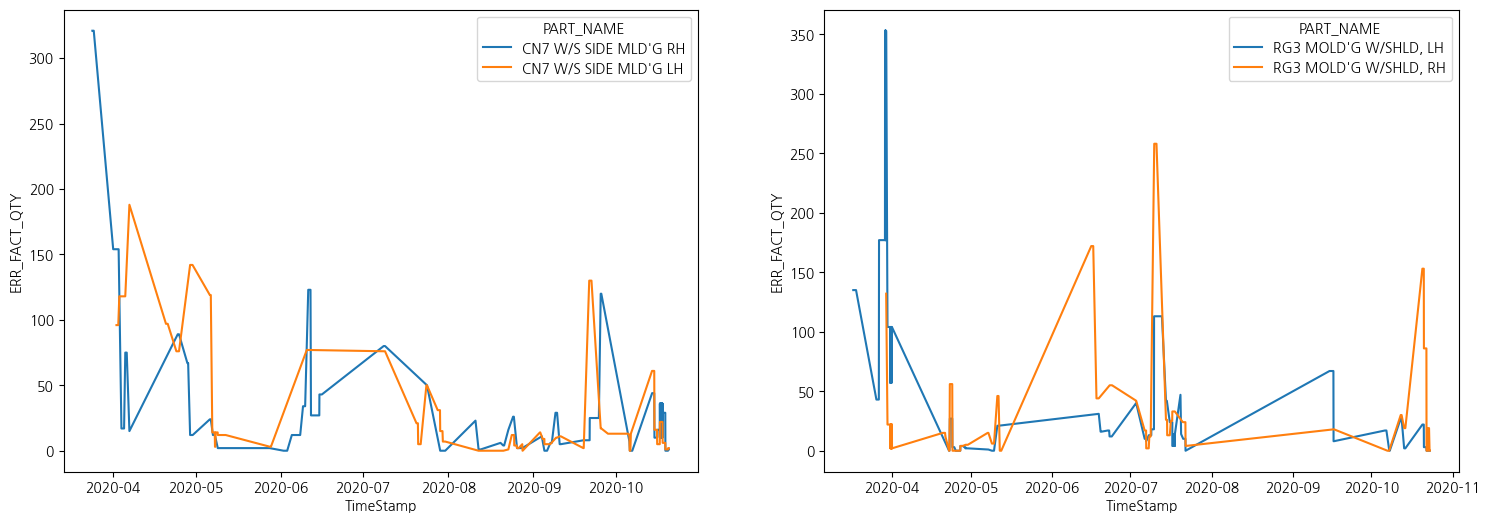

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.lineplot(data=unlab_cn7, x="TimeStamp", y="ERR_FACT_QTY", ax=axes[0], hue="PART_NAME")
sns.lineplot(data=unlab_rg3, x="TimeStamp", y="ERR_FACT_QTY", ax=axes[1], hue="PART_NAME")

plt.show()

## 제품별 불량품 발생 개수 분포

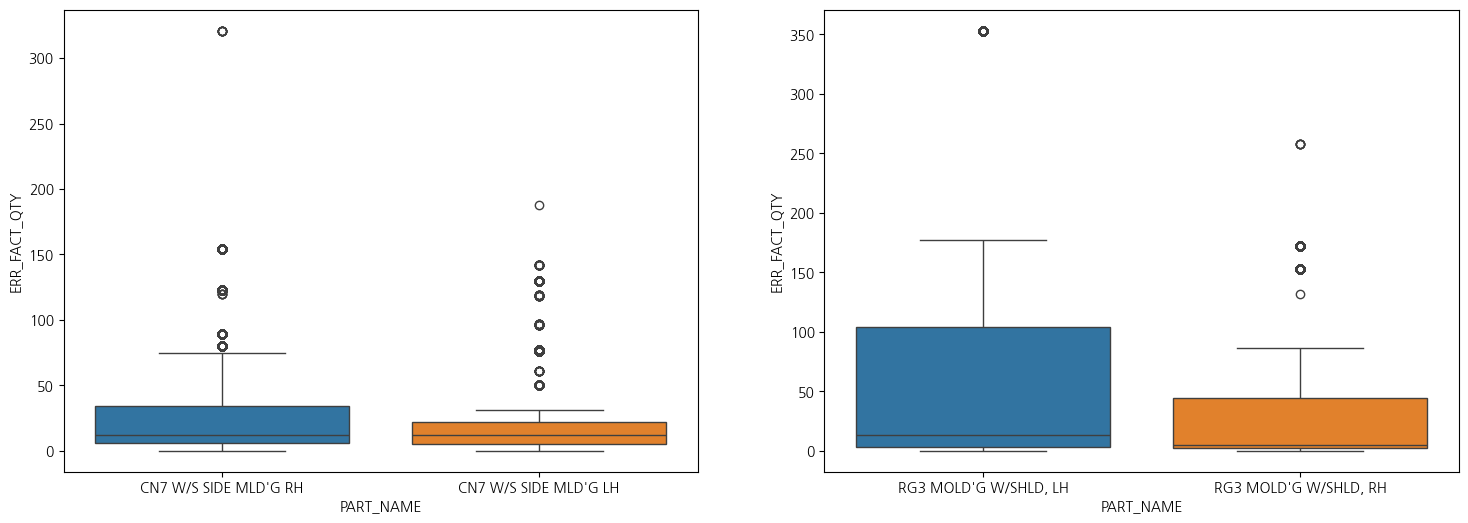

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(data=unlab_cn7, x='PART_NAME', y='ERR_FACT_QTY', ax=axes[0], hue="PART_NAME")
sns.boxplot(data=unlab_rg3, x='PART_NAME', y='ERR_FACT_QTY', ax=axes[1], hue="PART_NAME")

plt.show()

## 기기별 불량품 발생 개수 분포

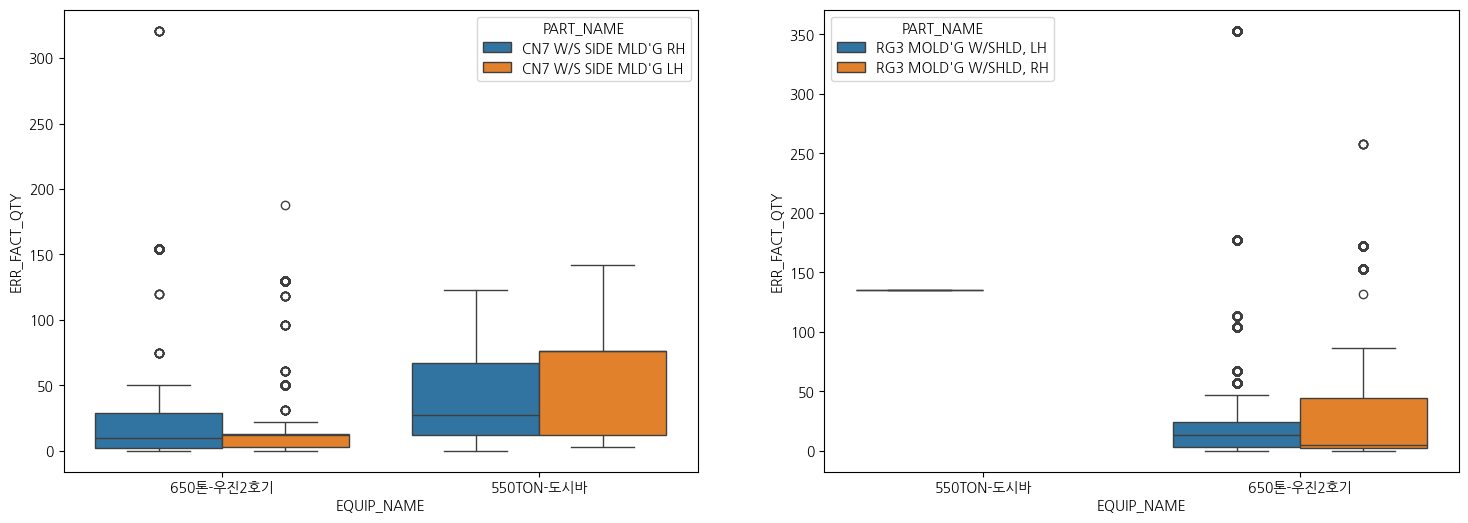

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(data=unlab_cn7, x='EQUIP_NAME', y='ERR_FACT_QTY', ax=axes[0], hue="PART_NAME")
sns.boxplot(data=unlab_rg3, x='EQUIP_NAME', y='ERR_FACT_QTY', ax=axes[1], hue="PART_NAME")

plt.show()

## ERR_FACT_QTY가 0인것과 아닌 것

In [ ]:
err_zero_cn7["PART_NAME"].value_counts()

PART_NAME
CN7 W/S SIDE MLD'G RH    3231
CN7 W/S SIDE MLD'G LH    1543
Name: count, dtype: int64

In [ ]:
err_zero_rg3["PART_NAME"].value_counts()

PART_NAME
RG3 MOLD'G W/SHLD, RH    3517
RG3 MOLD'G W/SHLD, LH    2100
Name: count, dtype: int64

In [ ]:
min(err_zero_cn7["TimeStamp"]), max(err_zero_cn7["TimeStamp"])

(Timestamp('2020-06-02 00:18:23'), Timestamp('2020-10-19 23:23:48'))

In [ ]:
min(err_zero_rg3["TimeStamp"]), max(err_zero_rg3["TimeStamp"])

(Timestamp('2020-04-22 18:11:19'), Timestamp('2020-10-23 05:30:10'))

### 변수별 박스플롯

In [ ]:
cols = ['Injection_Time', 'Filling_Time', 'Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Switch_Over_Position', 'Plasticizing_Position', 'Clamp_Open_Position',
       'Max_Injection_Speed', 'Max_Screw_RPM', 'Average_Screw_RPM',
       'Max_Injection_Pressure', 'Max_Switch_Over_Pressure',
       'Max_Back_Pressure', 'Average_Back_Pressure', 'Barrel_Temperature_1',
       'Barrel_Temperature_2', 'Barrel_Temperature_3', 'Barrel_Temperature_4',
       'Barrel_Temperature_5', 'Barrel_Temperature_6', 'Barrel_Temperature_7',
       'Hopper_Temperature','Mold_Temperature_3', 'Mold_Temperature_4']

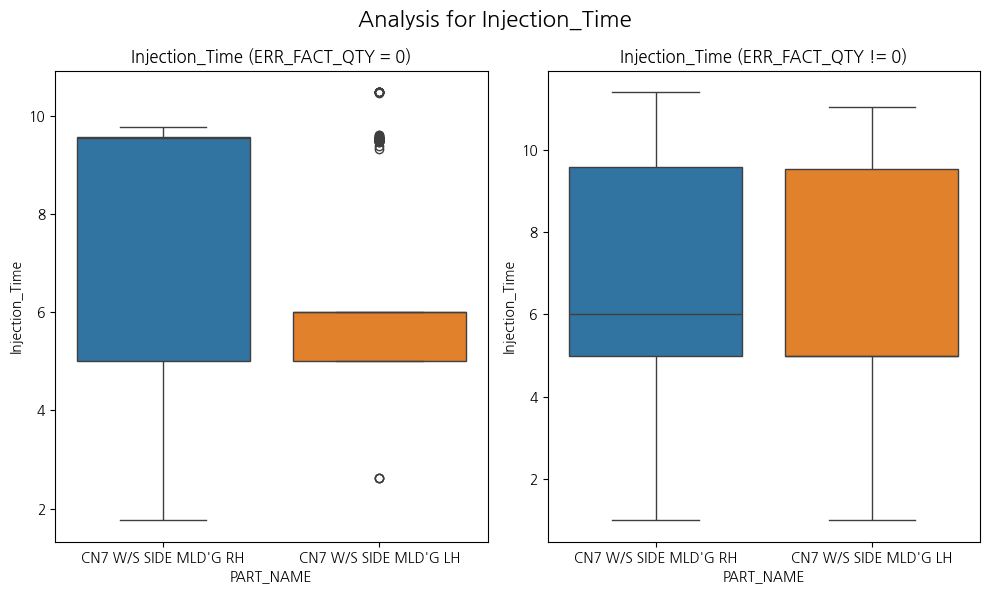

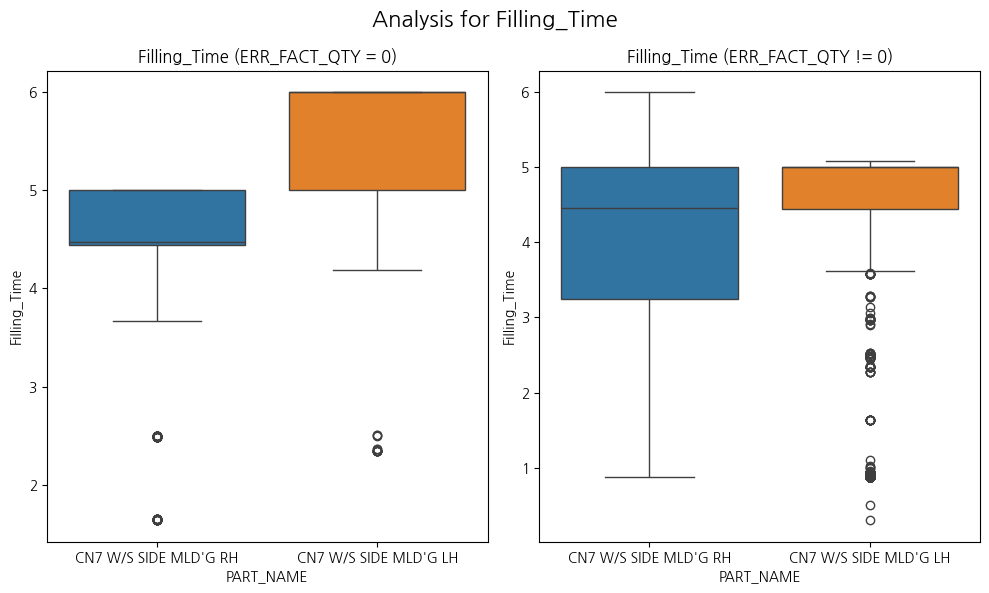

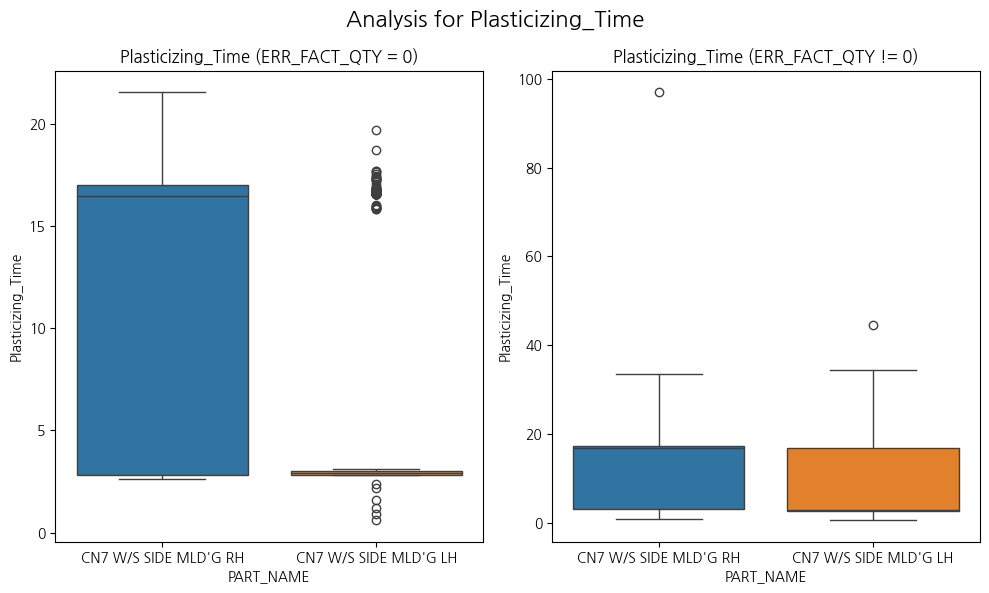

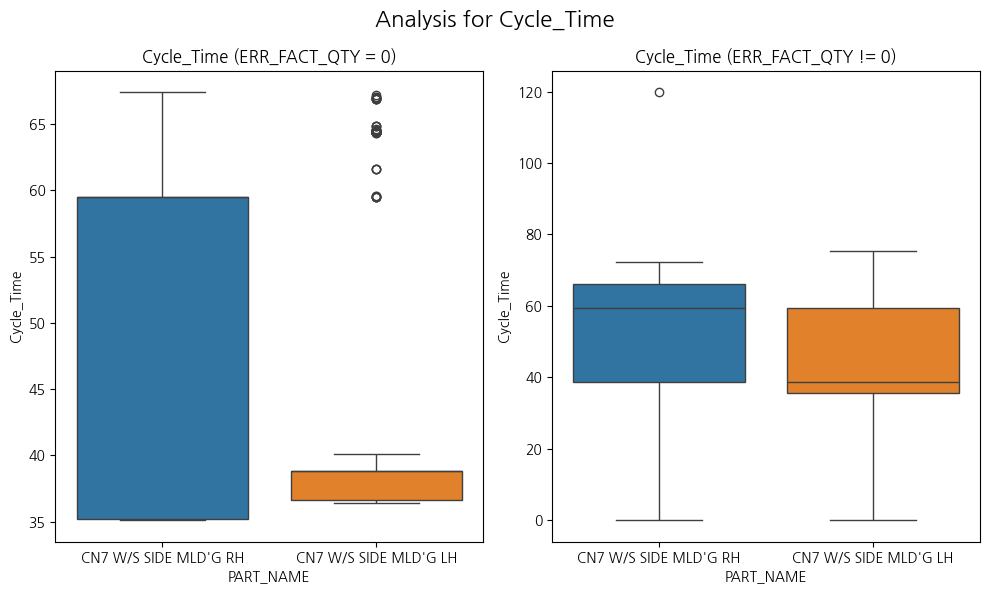

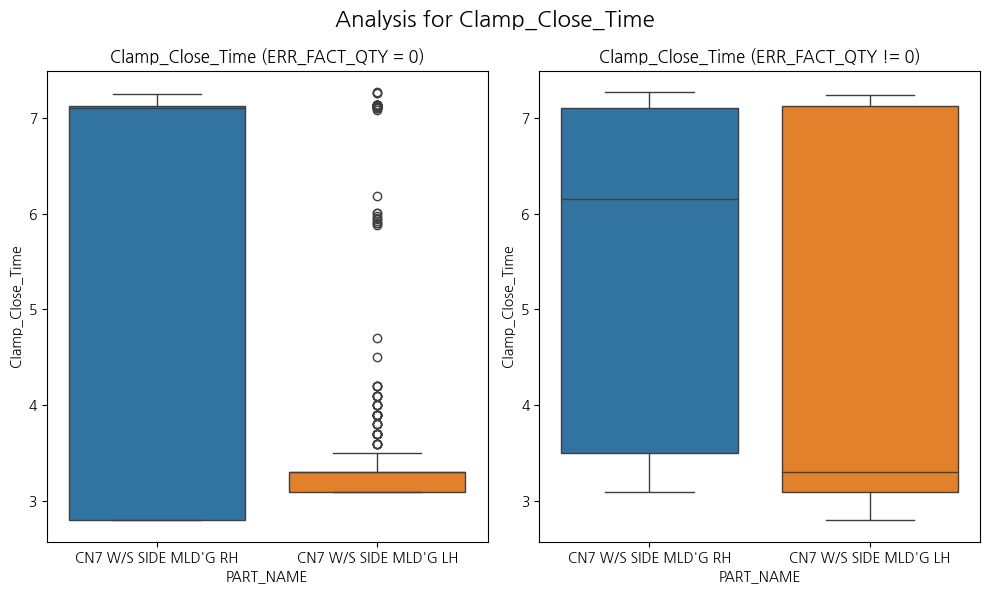

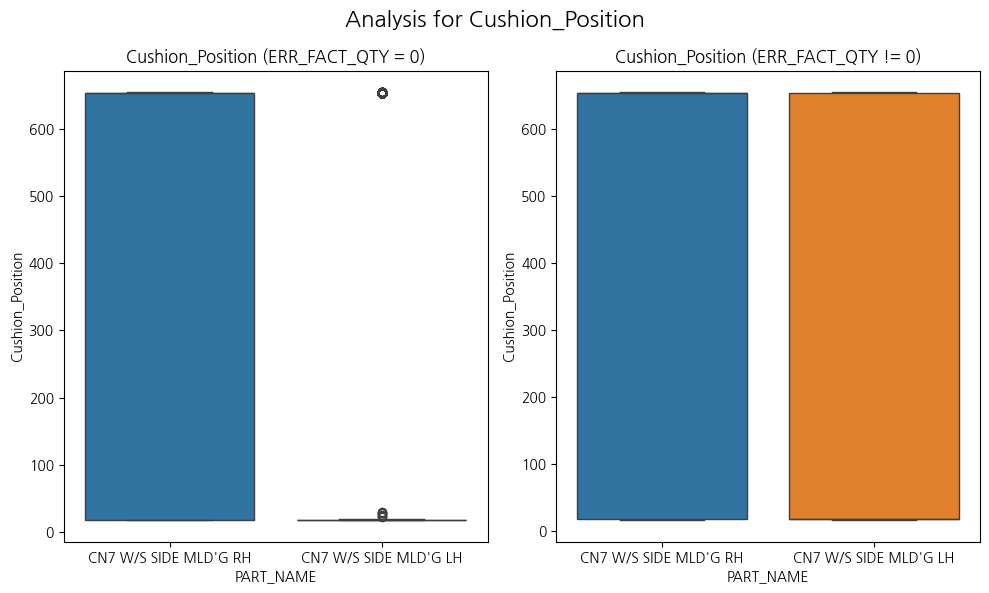

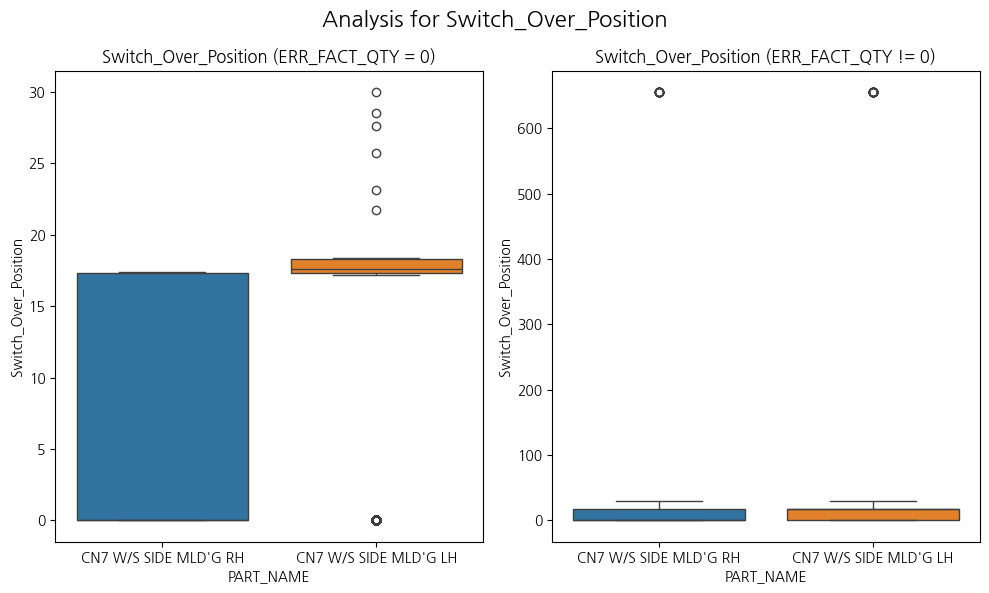

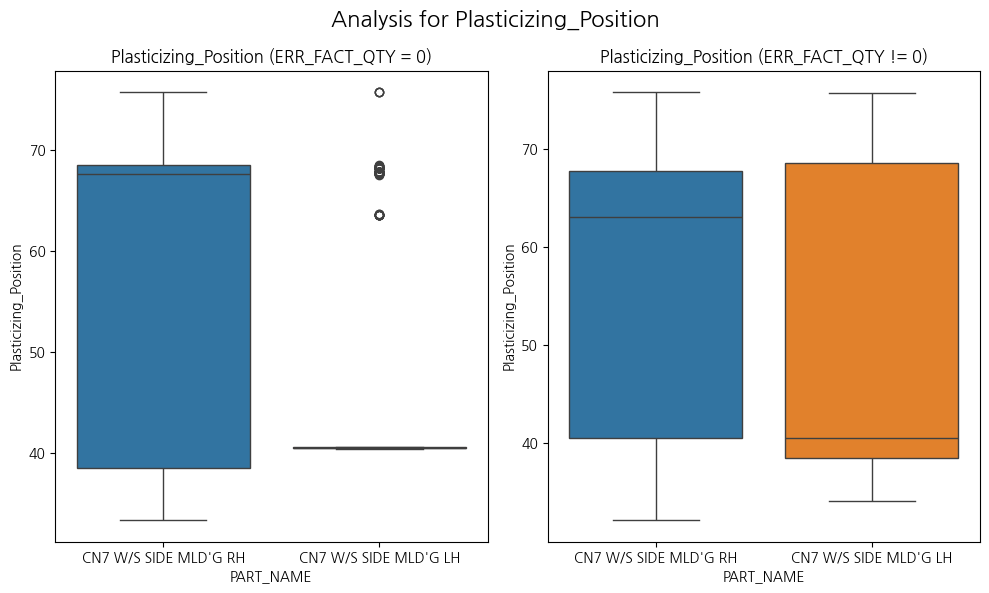

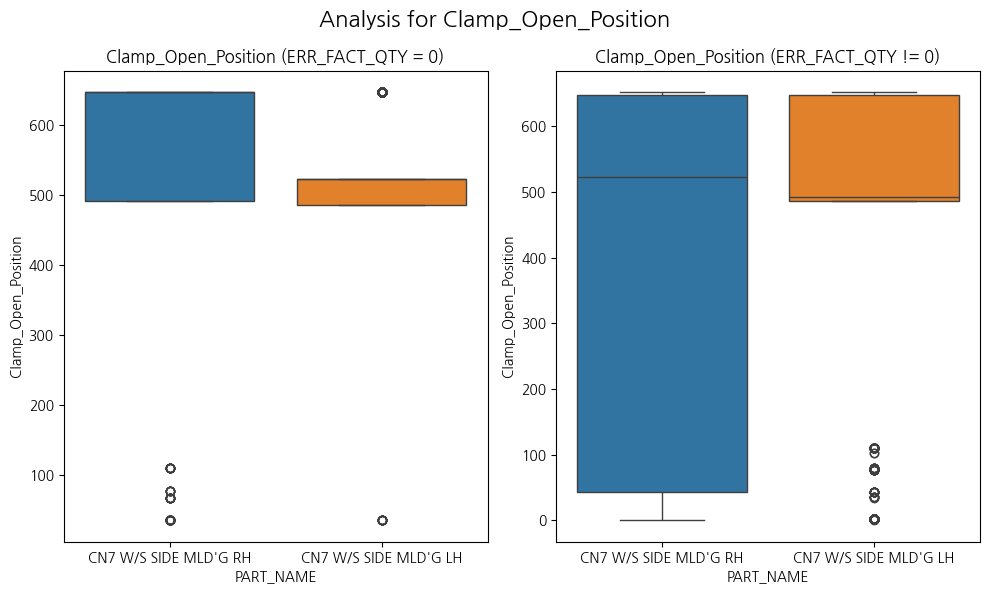

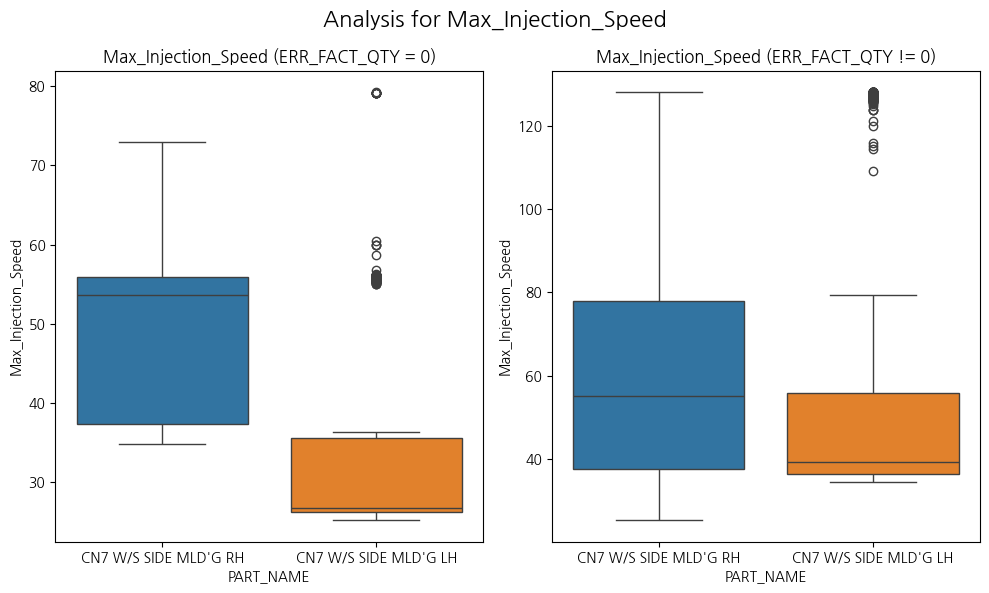

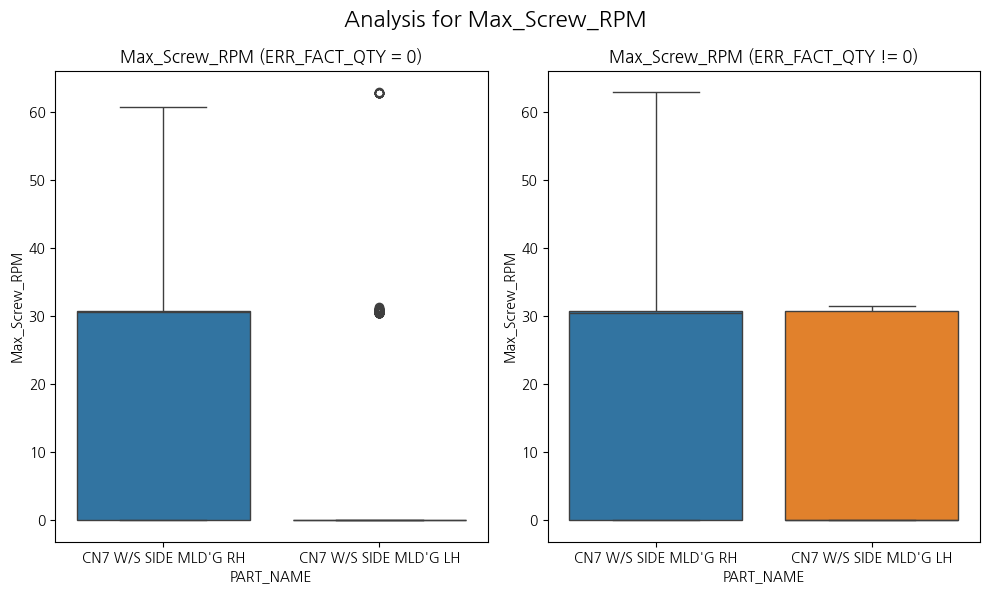

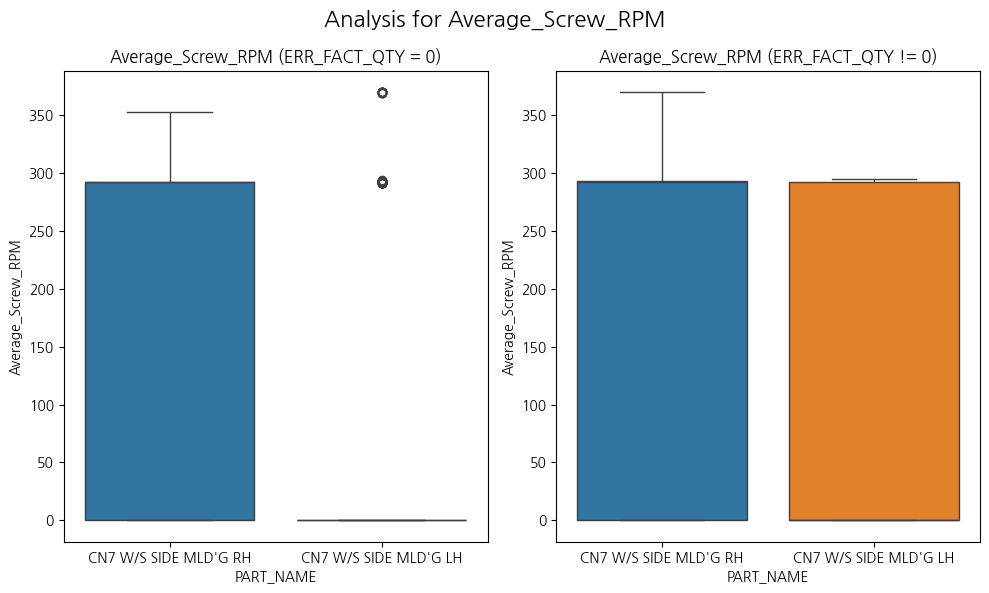

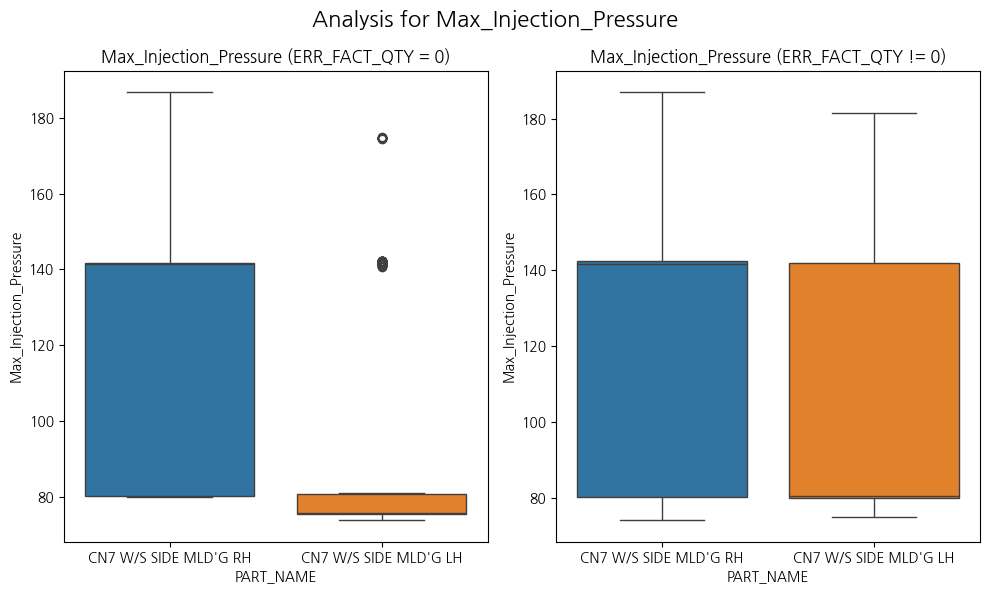

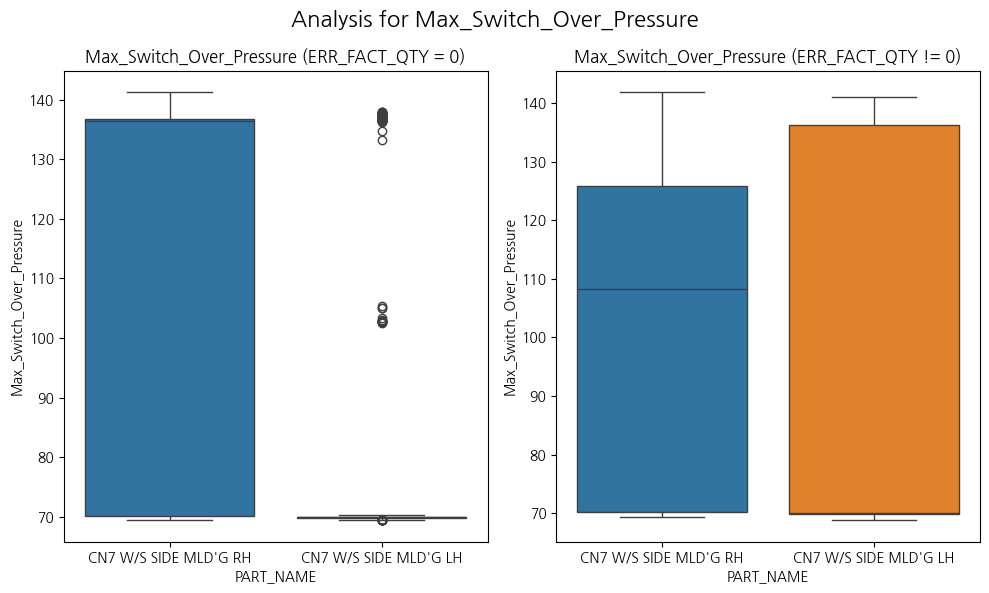

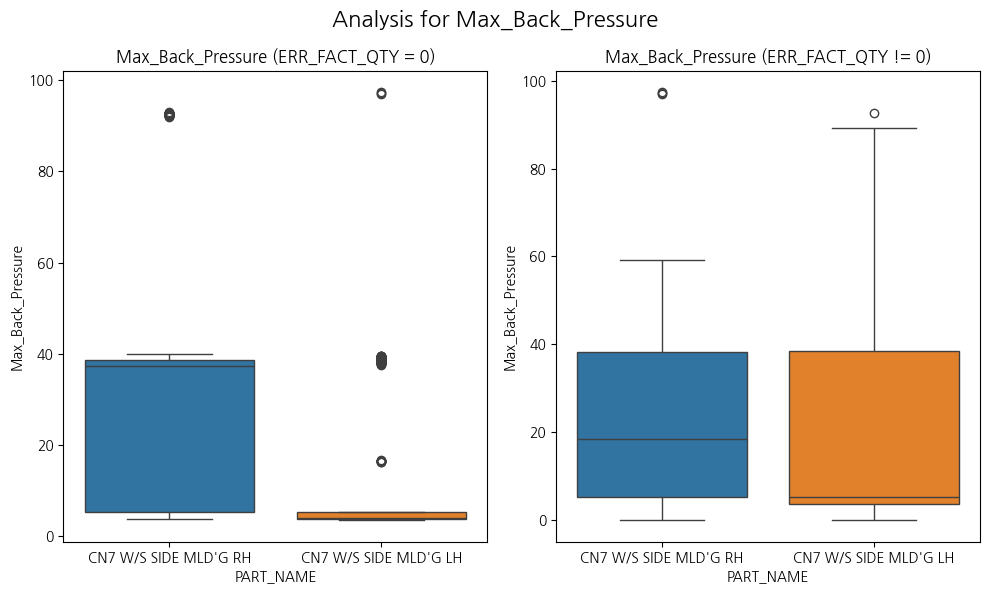

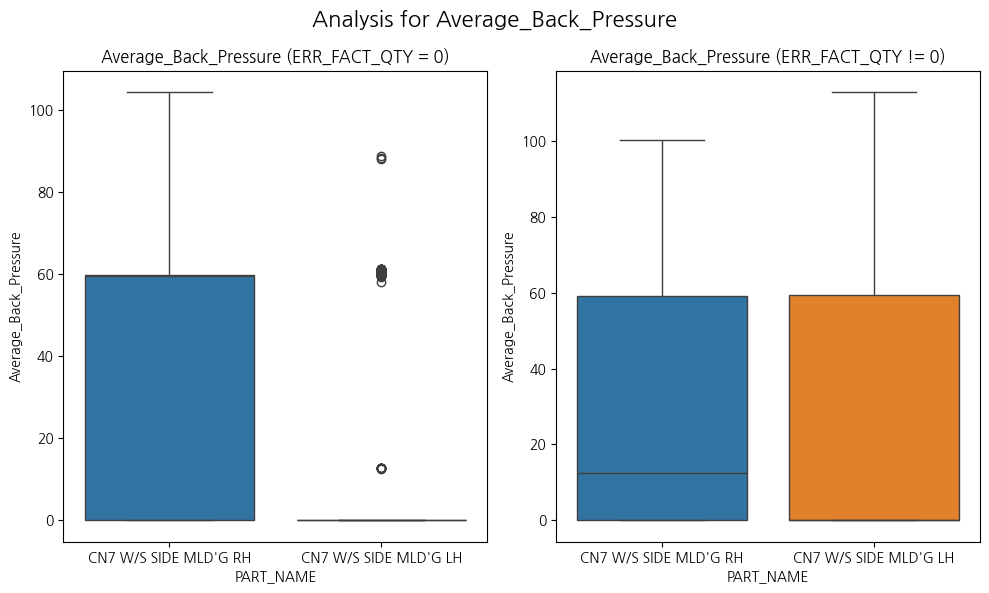

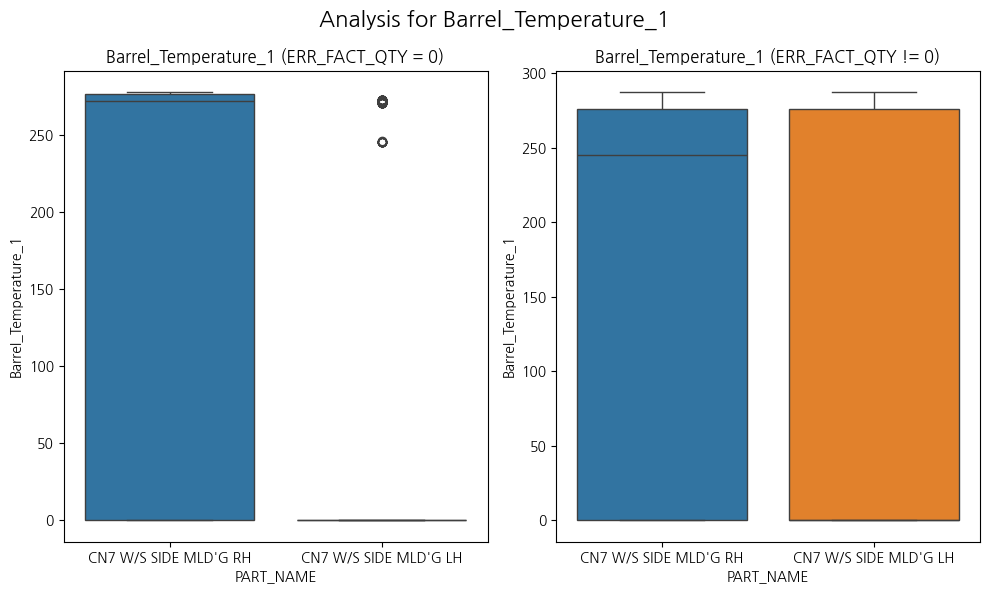

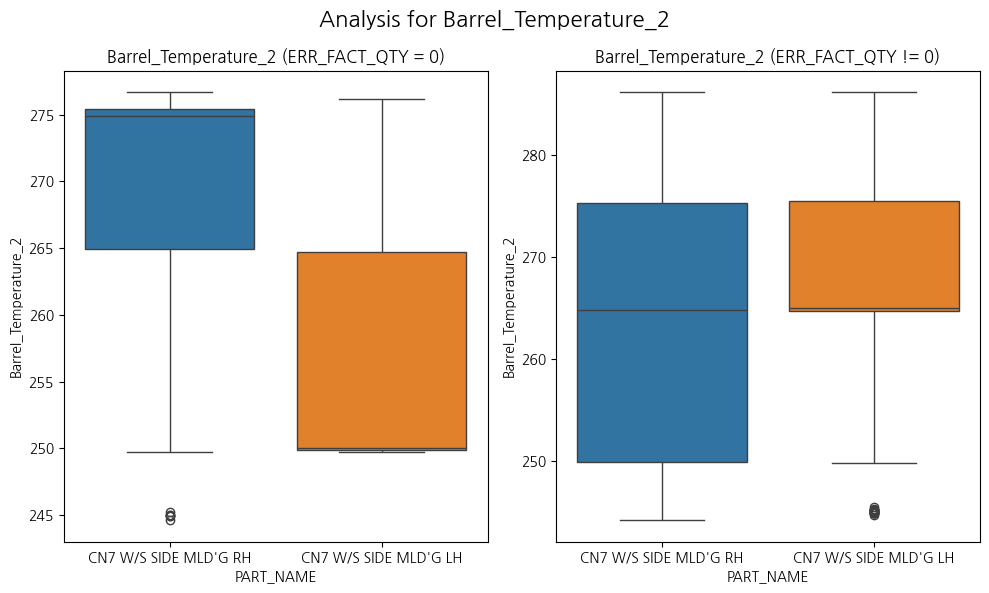

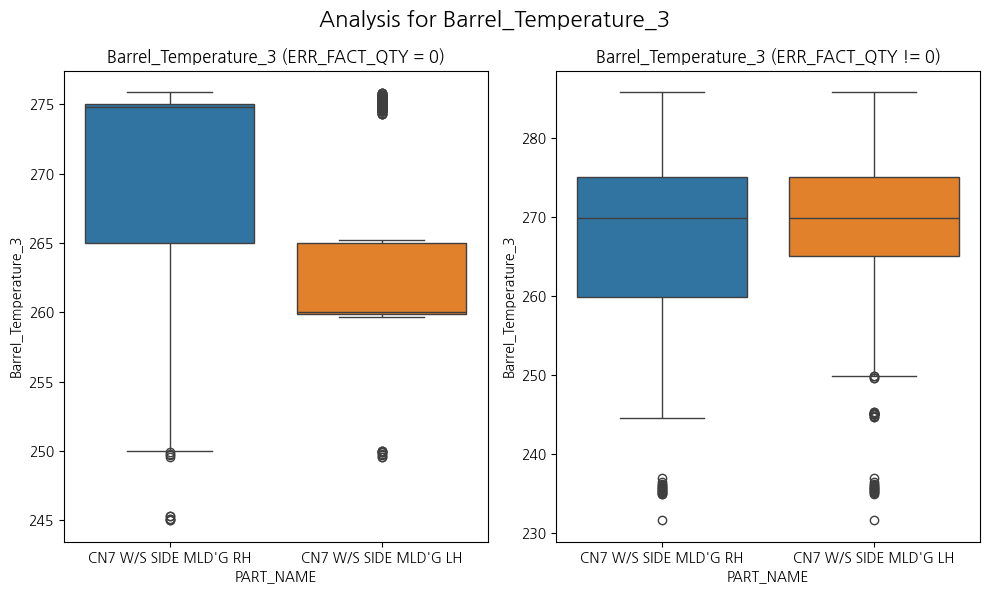

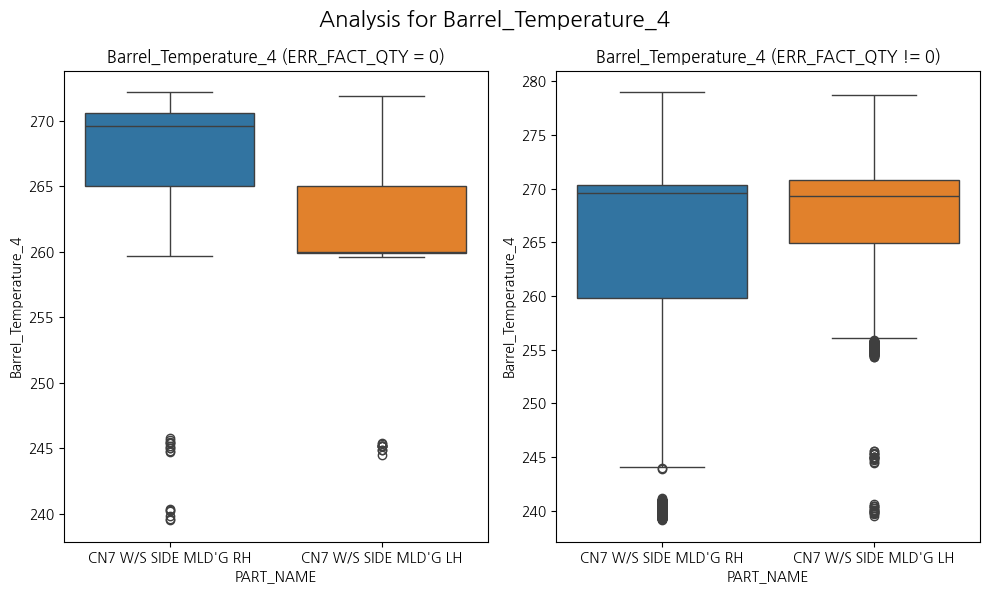

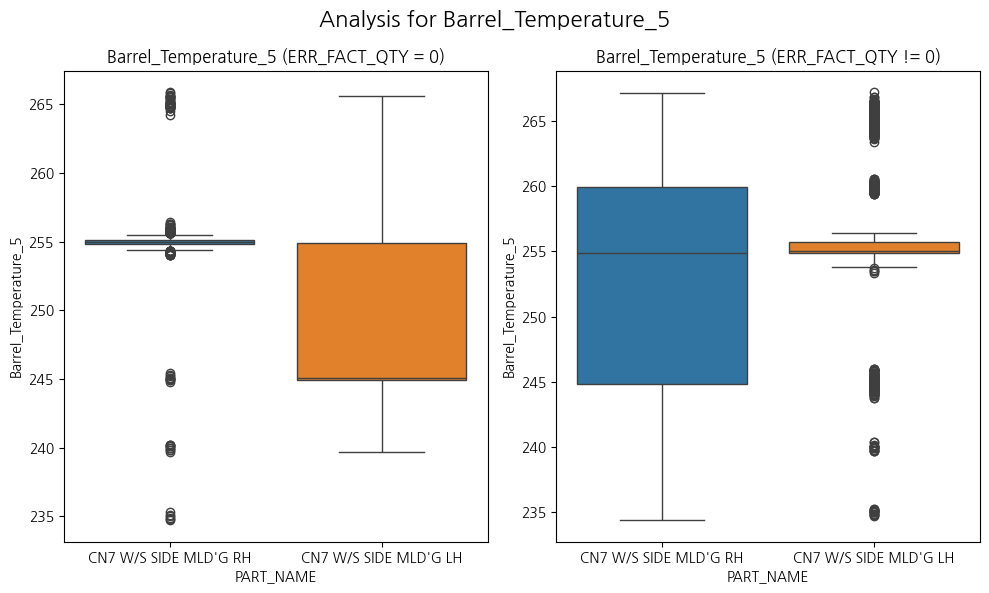

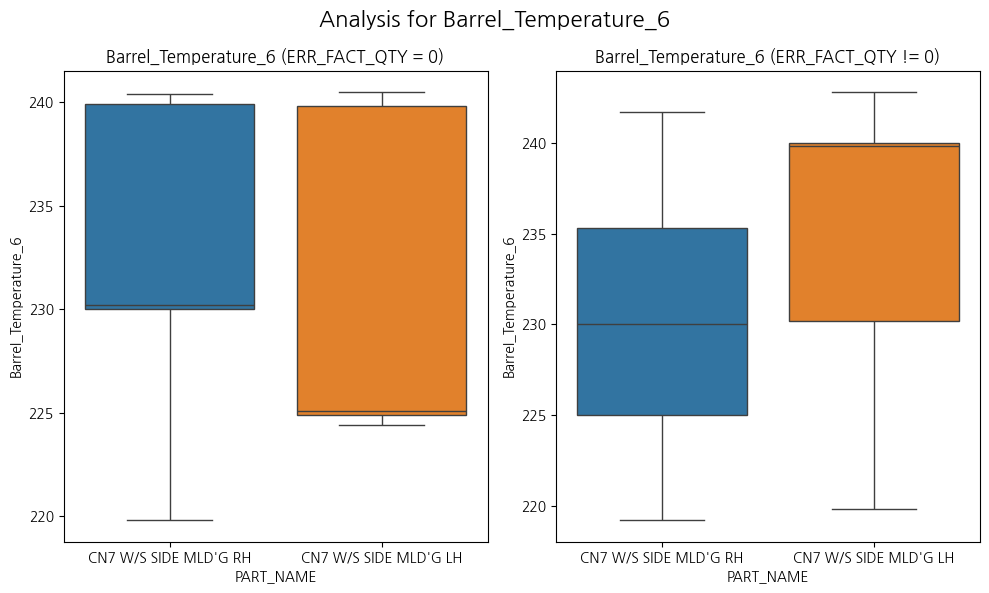

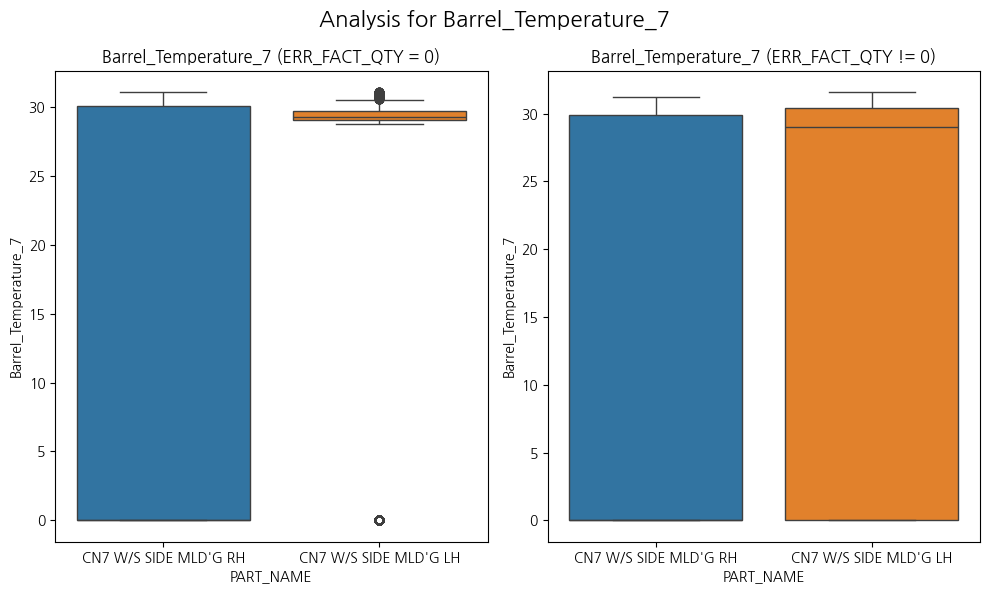

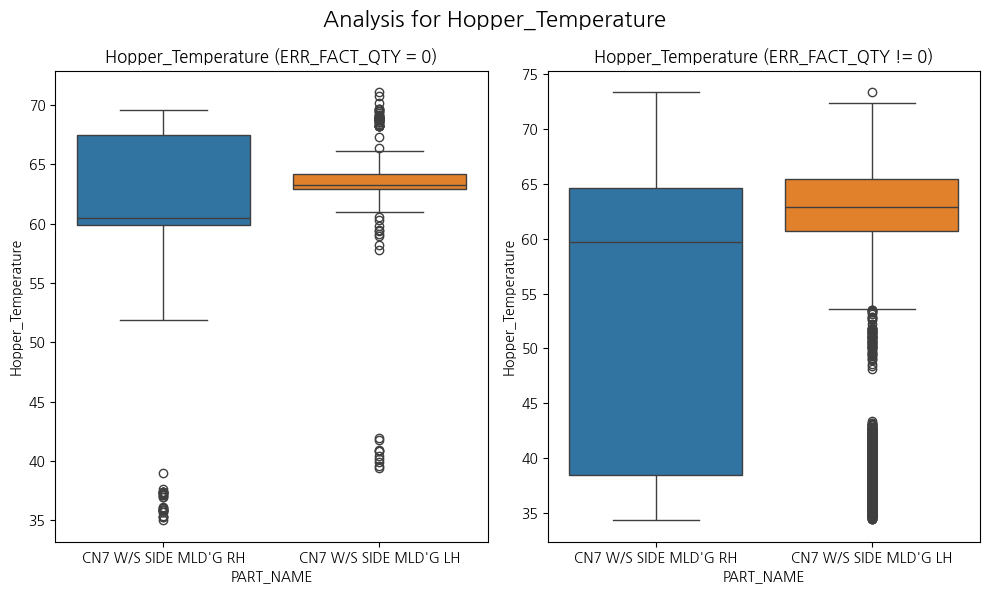

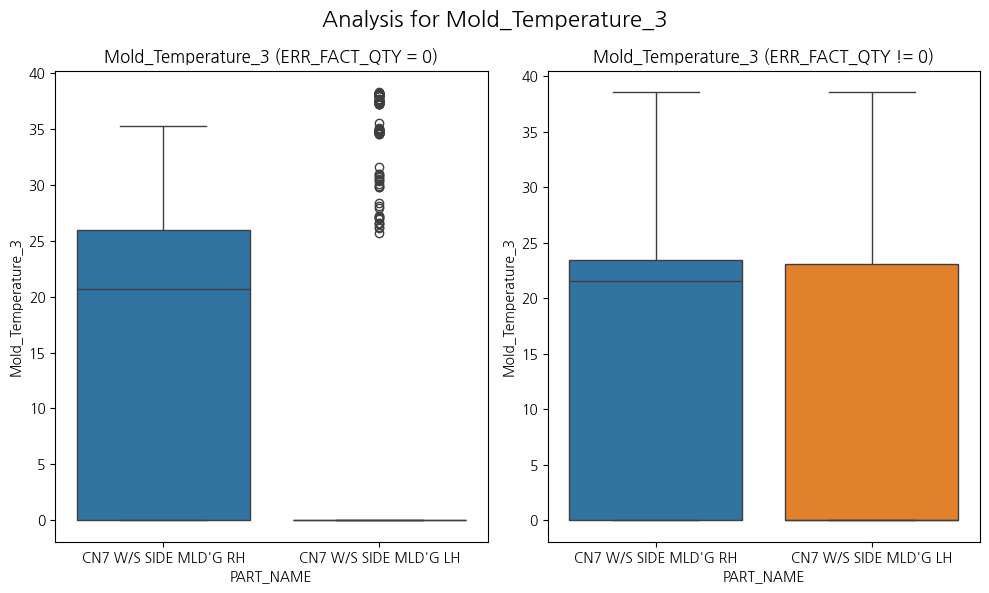

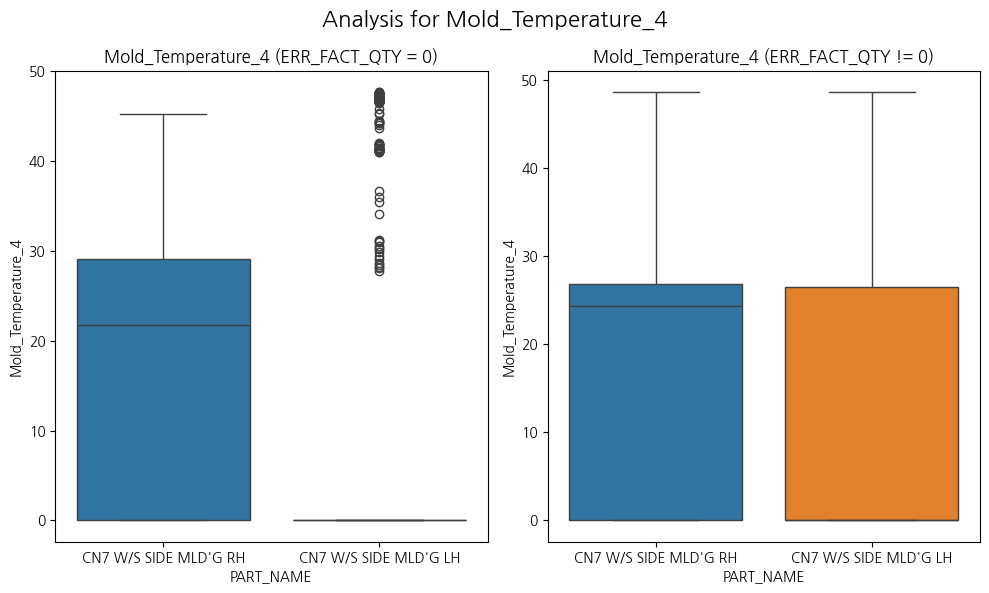

In [ ]:
for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    sns.boxplot(data=err_zero_cn7, x='PART_NAME', y=col, ax=axes[0], hue="PART_NAME")
    axes[0].set_title(f"{col} (ERR_FACT_QTY = 0)", fontsize=12)

    sns.boxplot(data=non_zero_cn7, x='PART_NAME', y=col, ax=axes[1], hue="PART_NAME")
    axes[1].set_title(f"{col} (ERR_FACT_QTY != 0)", fontsize=12)

    file_name = os.path.join(DATA_PATH, f"{col}_analysis.png")
    plt.savefig(file_name, dpi=300, bbox_inches='tight')  # 저장

    plt.suptitle(f"Analysis for {col}", fontsize=16)
    plt.tight_layout()
    plt.show()

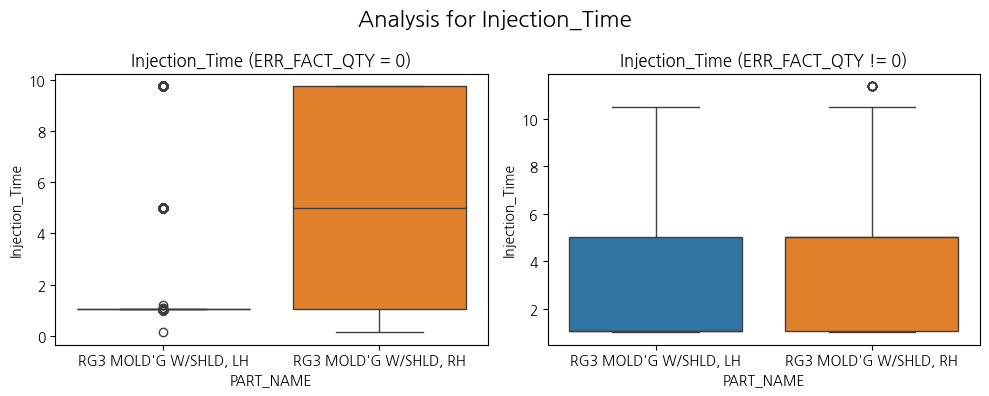

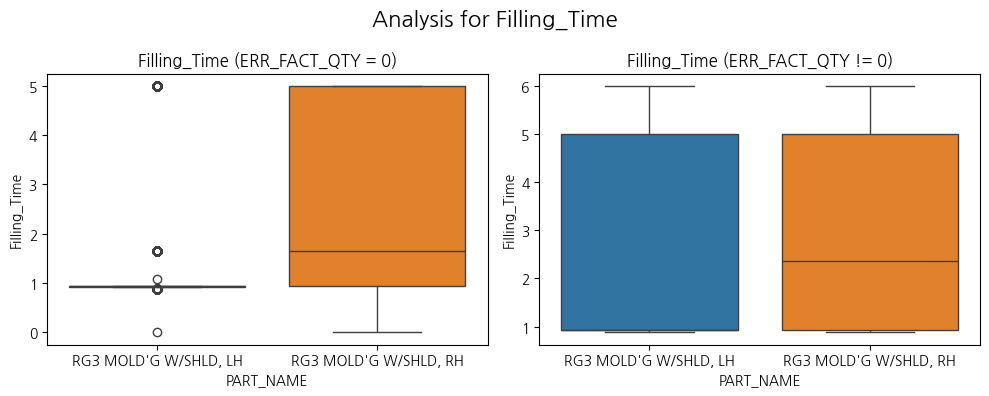

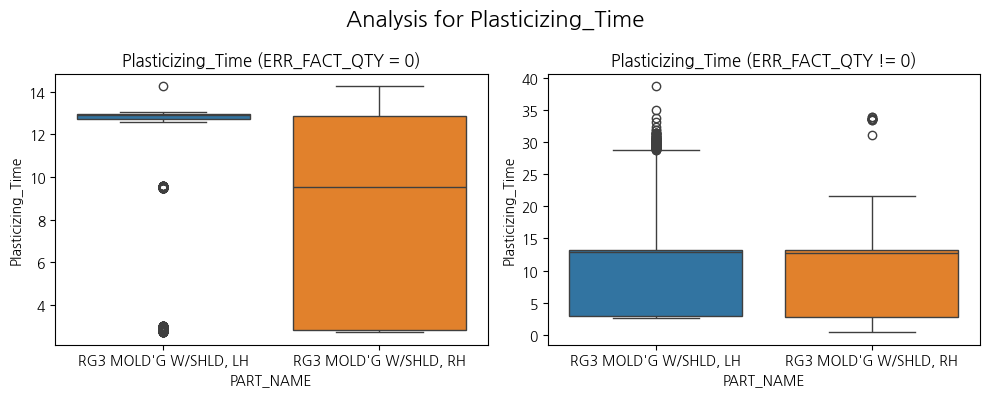

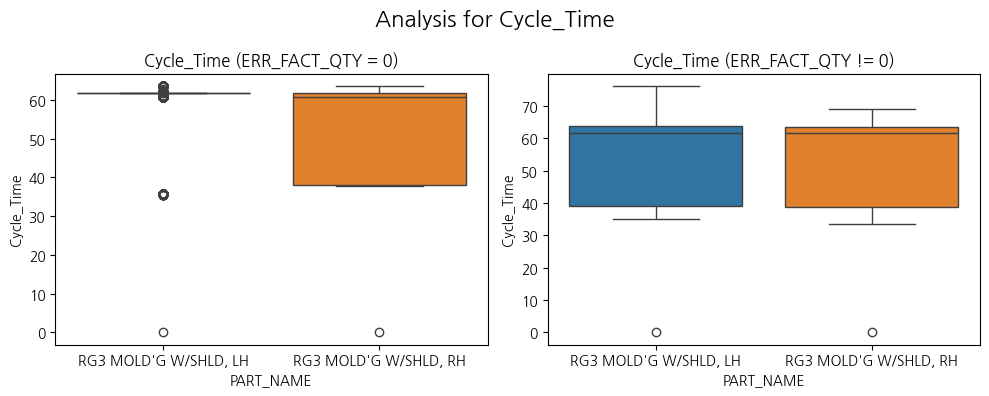

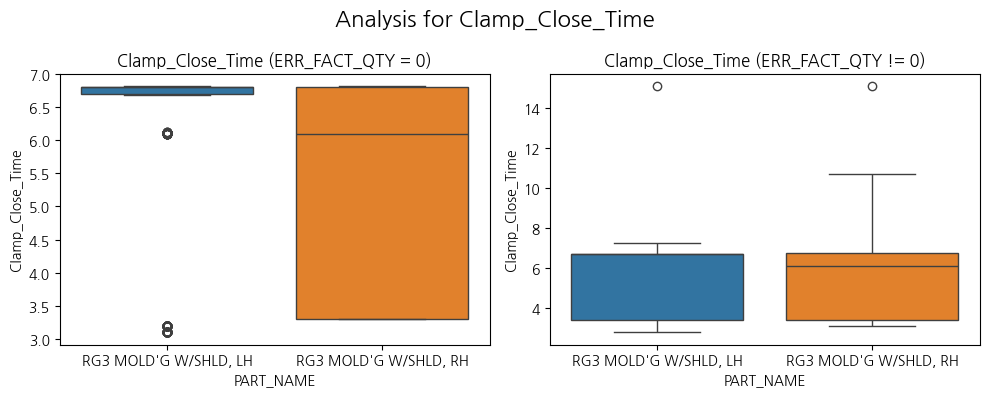

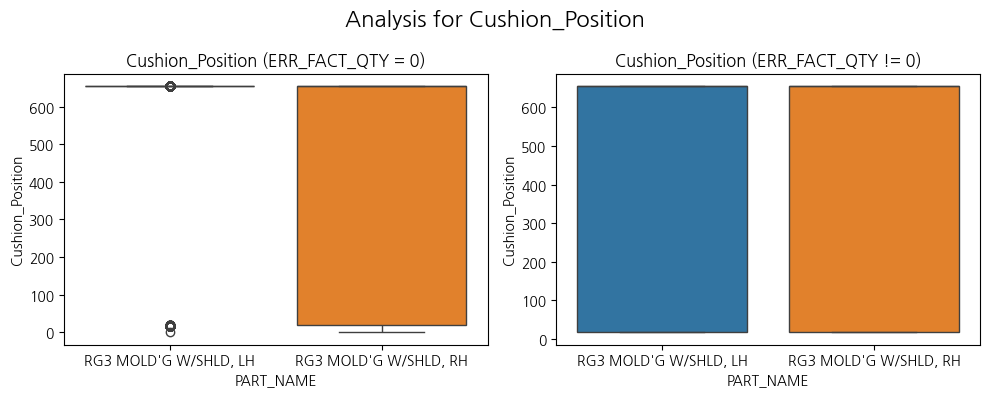

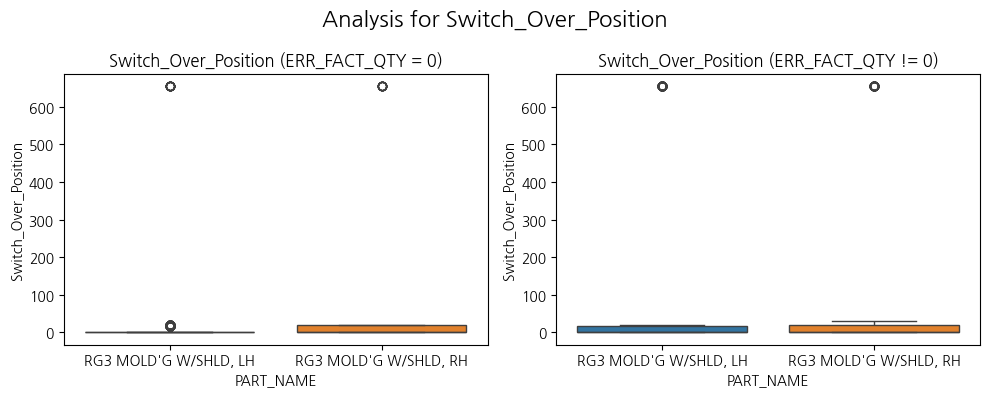

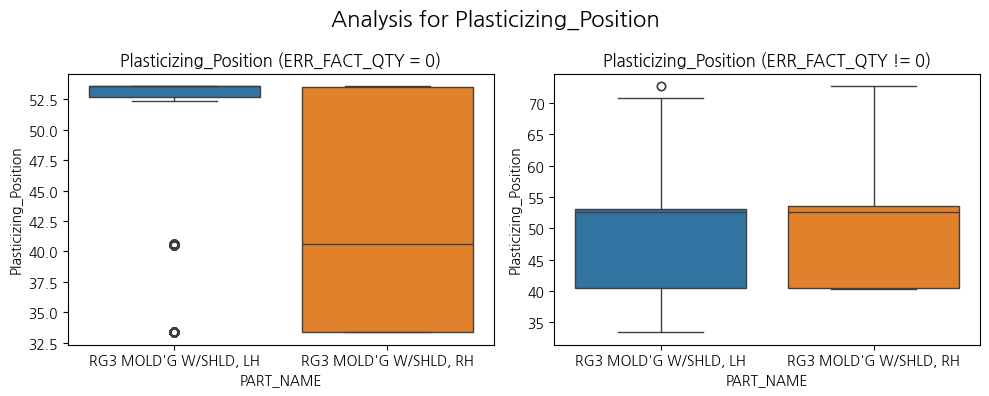

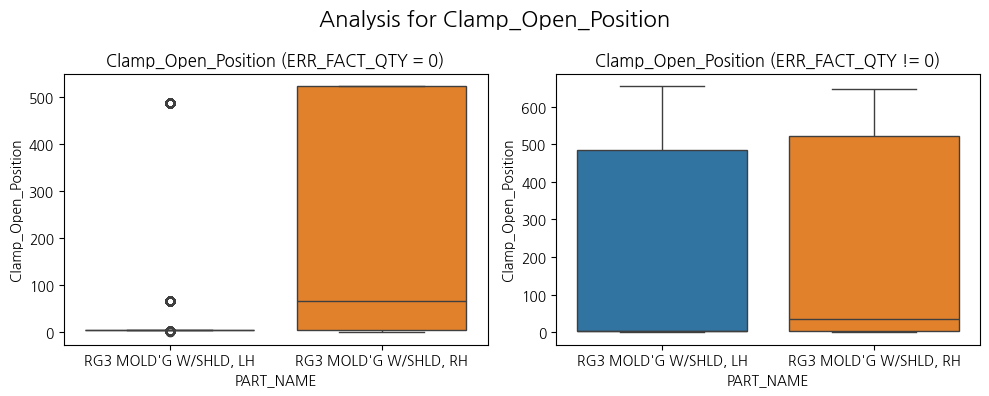

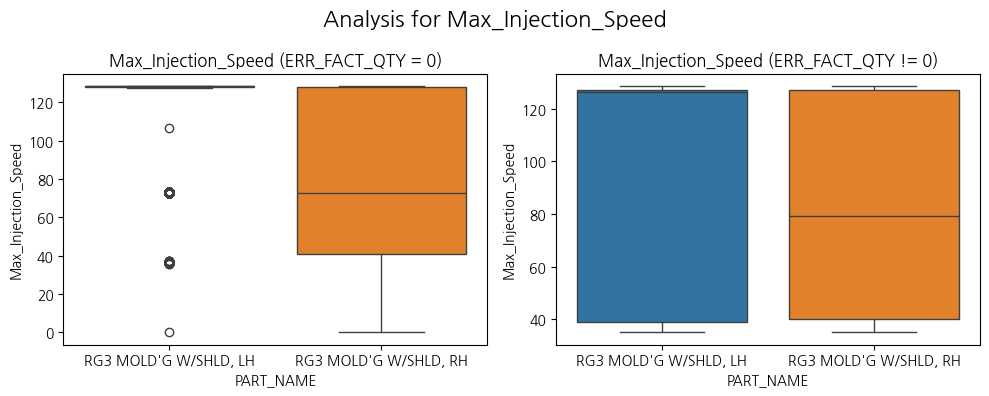

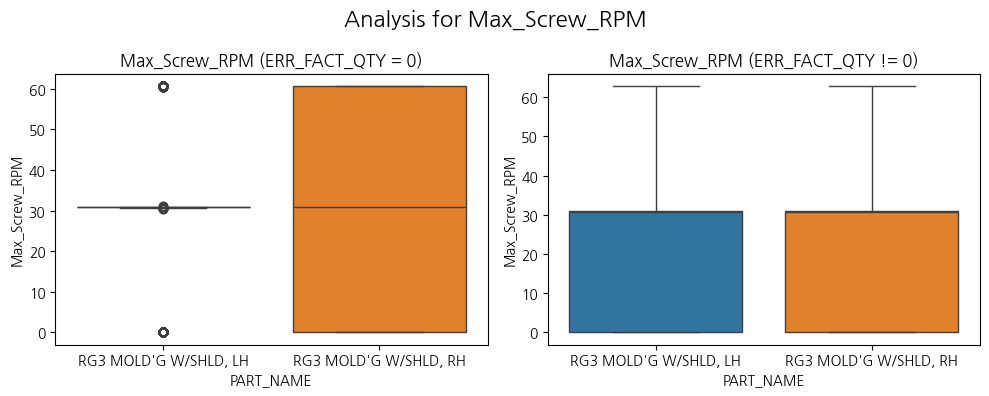

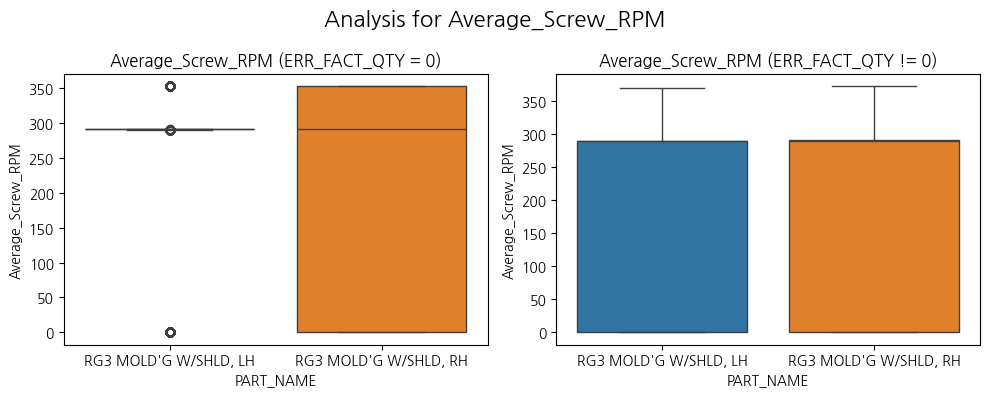

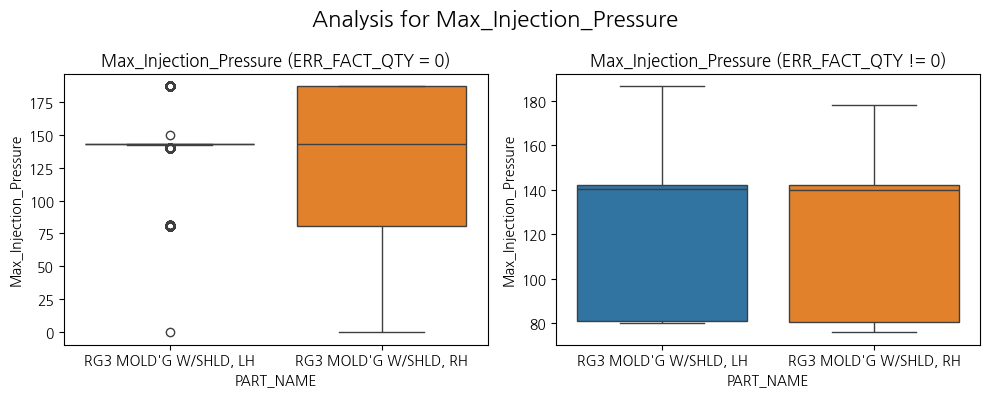

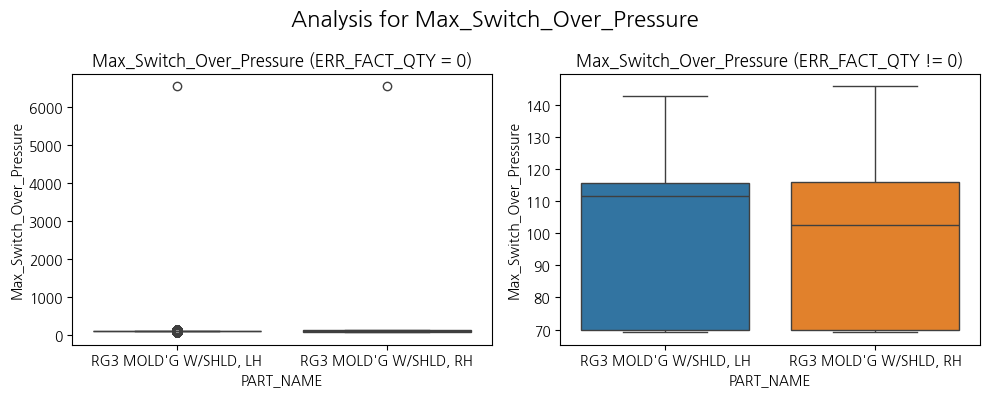

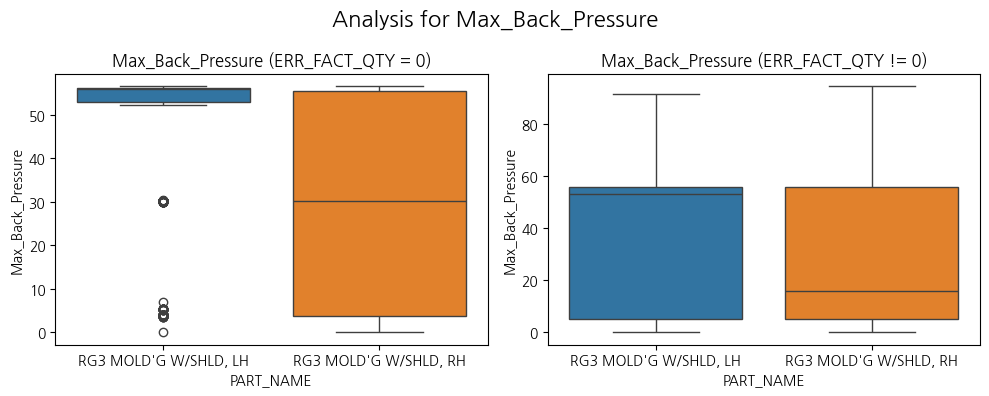

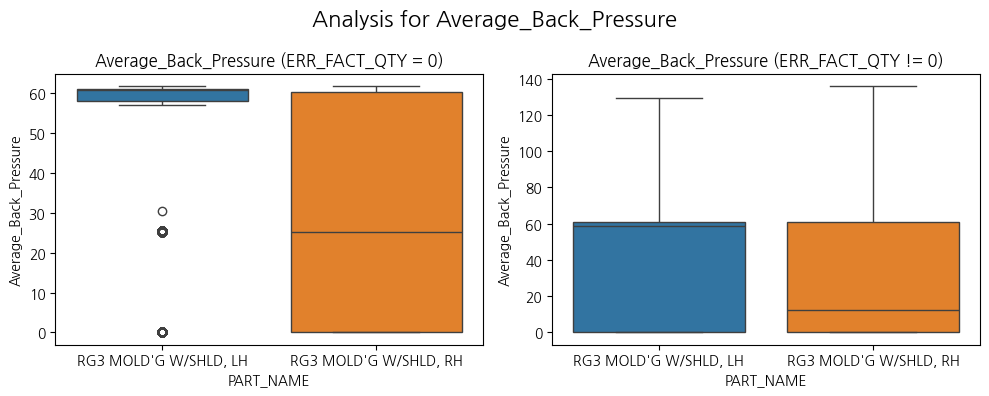

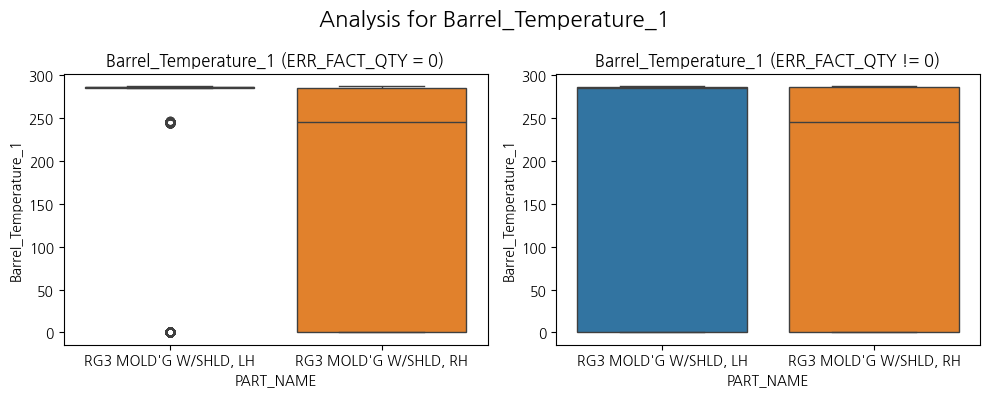

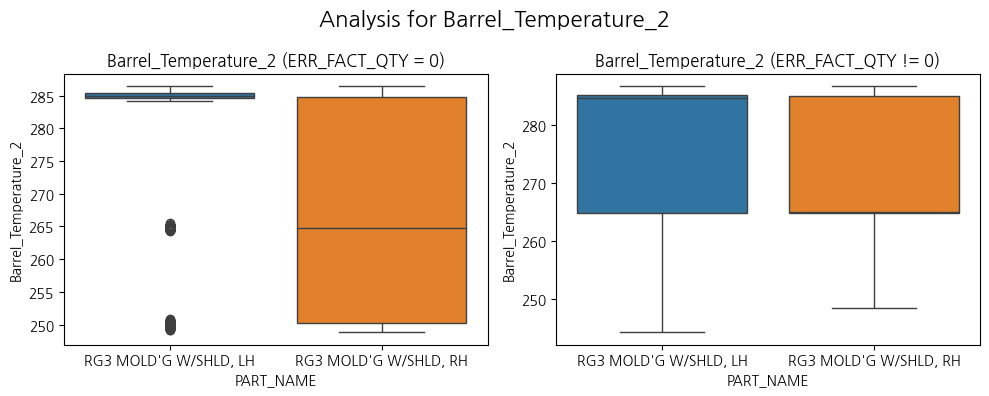

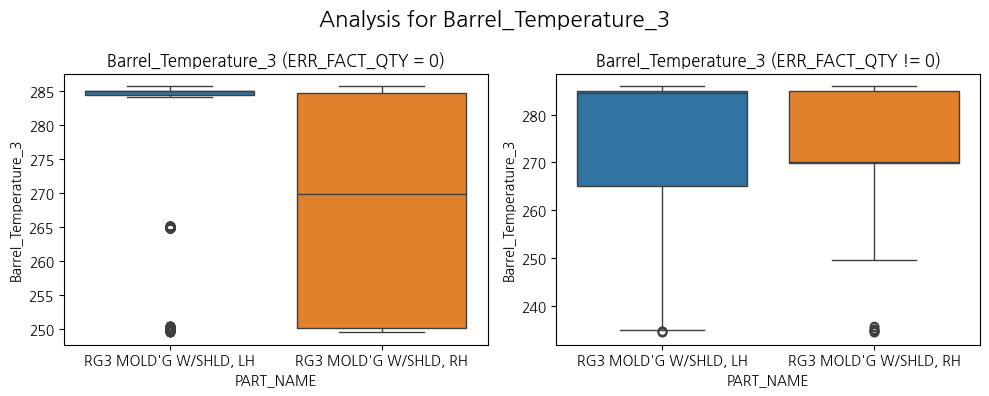

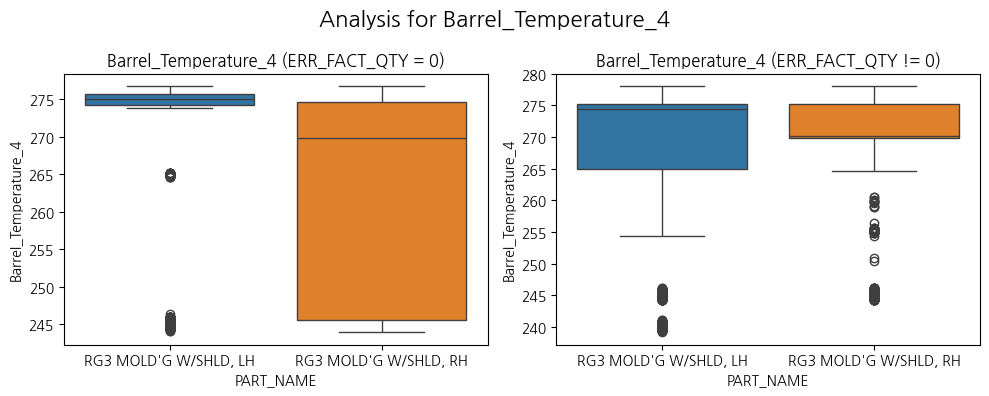

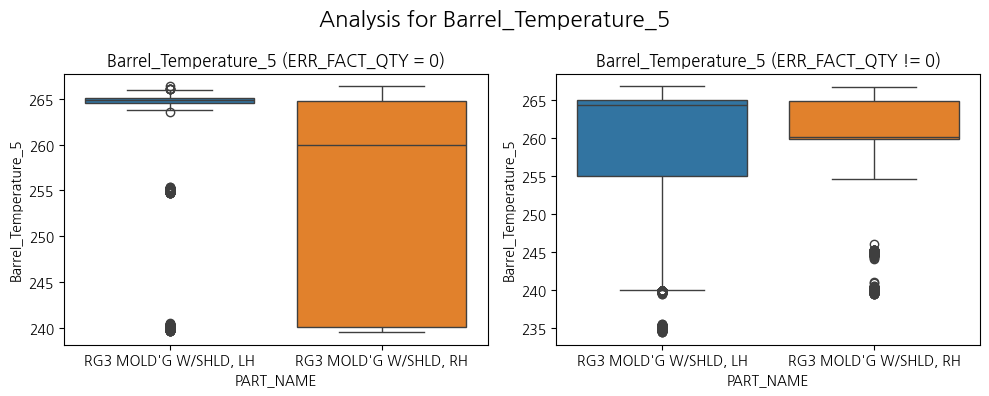

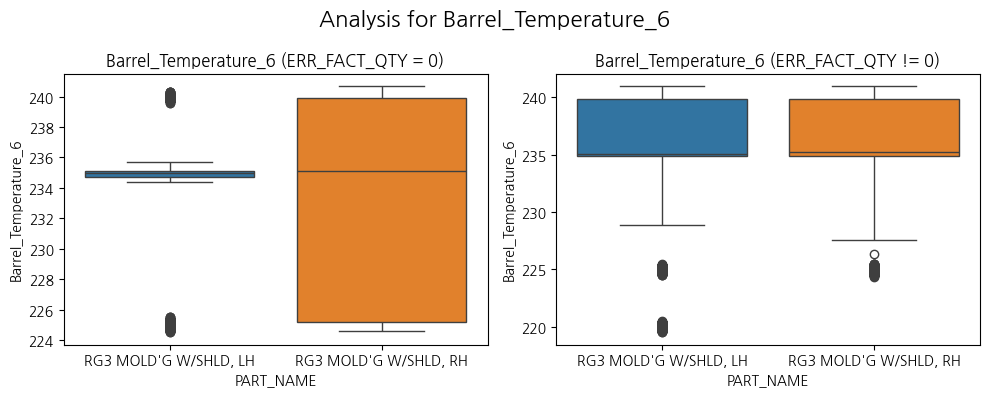

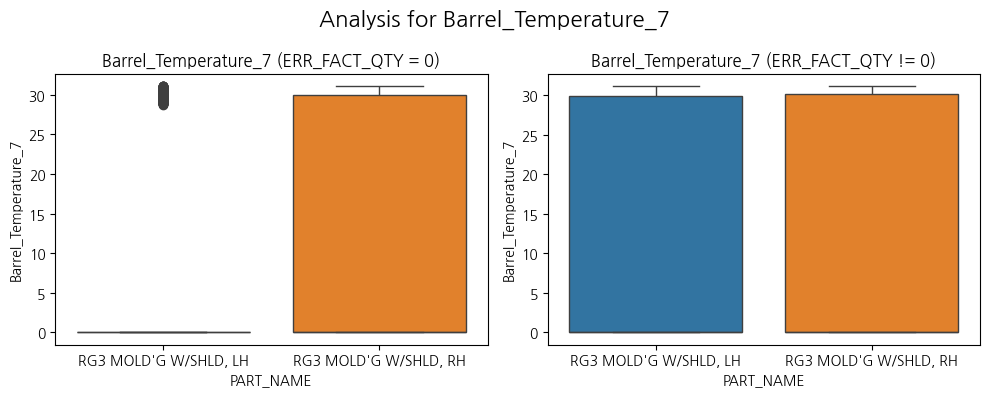

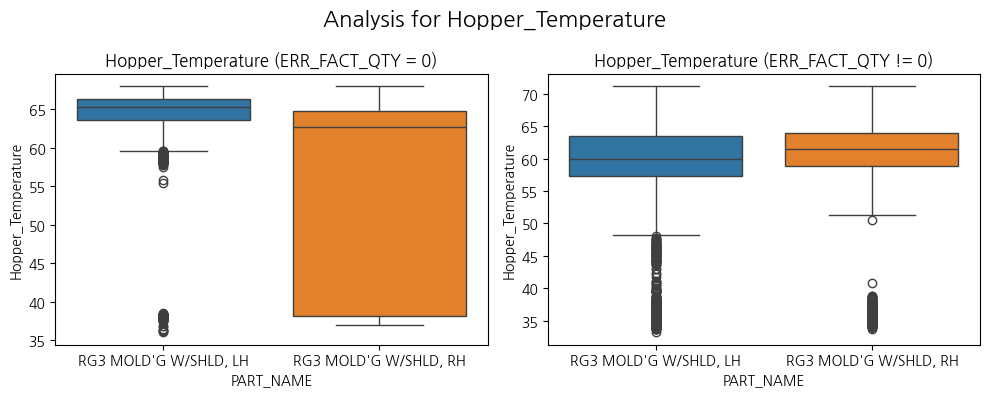

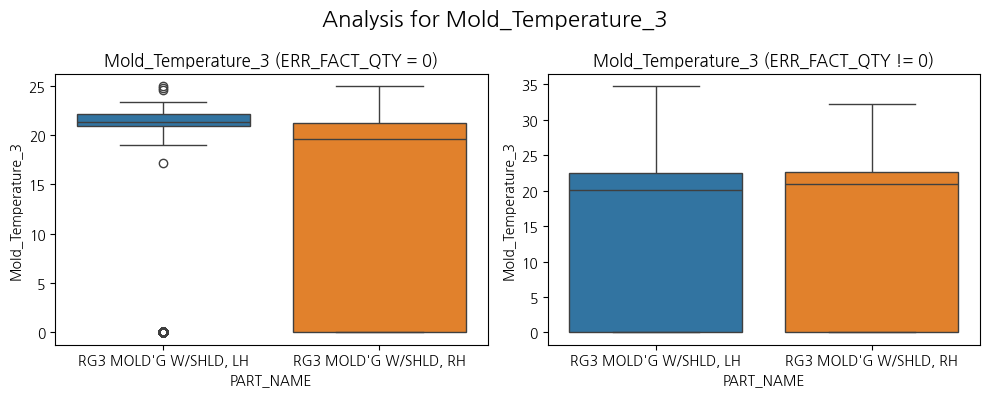

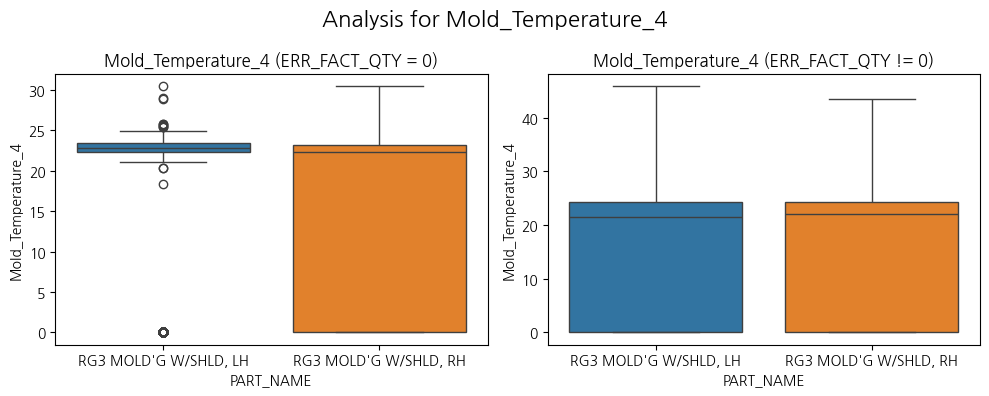

In [ ]:
for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.boxplot(data=err_zero_rg3, x='PART_NAME', y=col, ax=axes[0], hue="PART_NAME")
    axes[0].set_title(f"{col} (ERR_FACT_QTY = 0)", fontsize=12)

    sns.boxplot(data=non_zero_rg3, x='PART_NAME', y=col, ax=axes[1], hue="PART_NAME")
    axes[1].set_title(f"{col} (ERR_FACT_QTY != 0)", fontsize=12)

    plt.suptitle(f"Analysis for {col}", fontsize=16)
    plt.tight_layout()
    plt.show()

### 변수간 상관관계 확인

#### Labeled

In [ ]:
df_cn7 = pd.concat([train_cn7, test_cn7], axis=0)
df_rg3 = pd.concat([train_rg3, test_rg3], axis=0)

df_cn7.shape, df_rg3.shape

((3974, 45), (1256, 45))

In [ ]:
df_rg3_Y.drop(columns=["PART_FACT_SERIAL"], inplace=True)

<ipython-input-12-52627e5a22d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rg3_Y.drop(columns=["PART_FACT_SERIAL"], inplace=True)


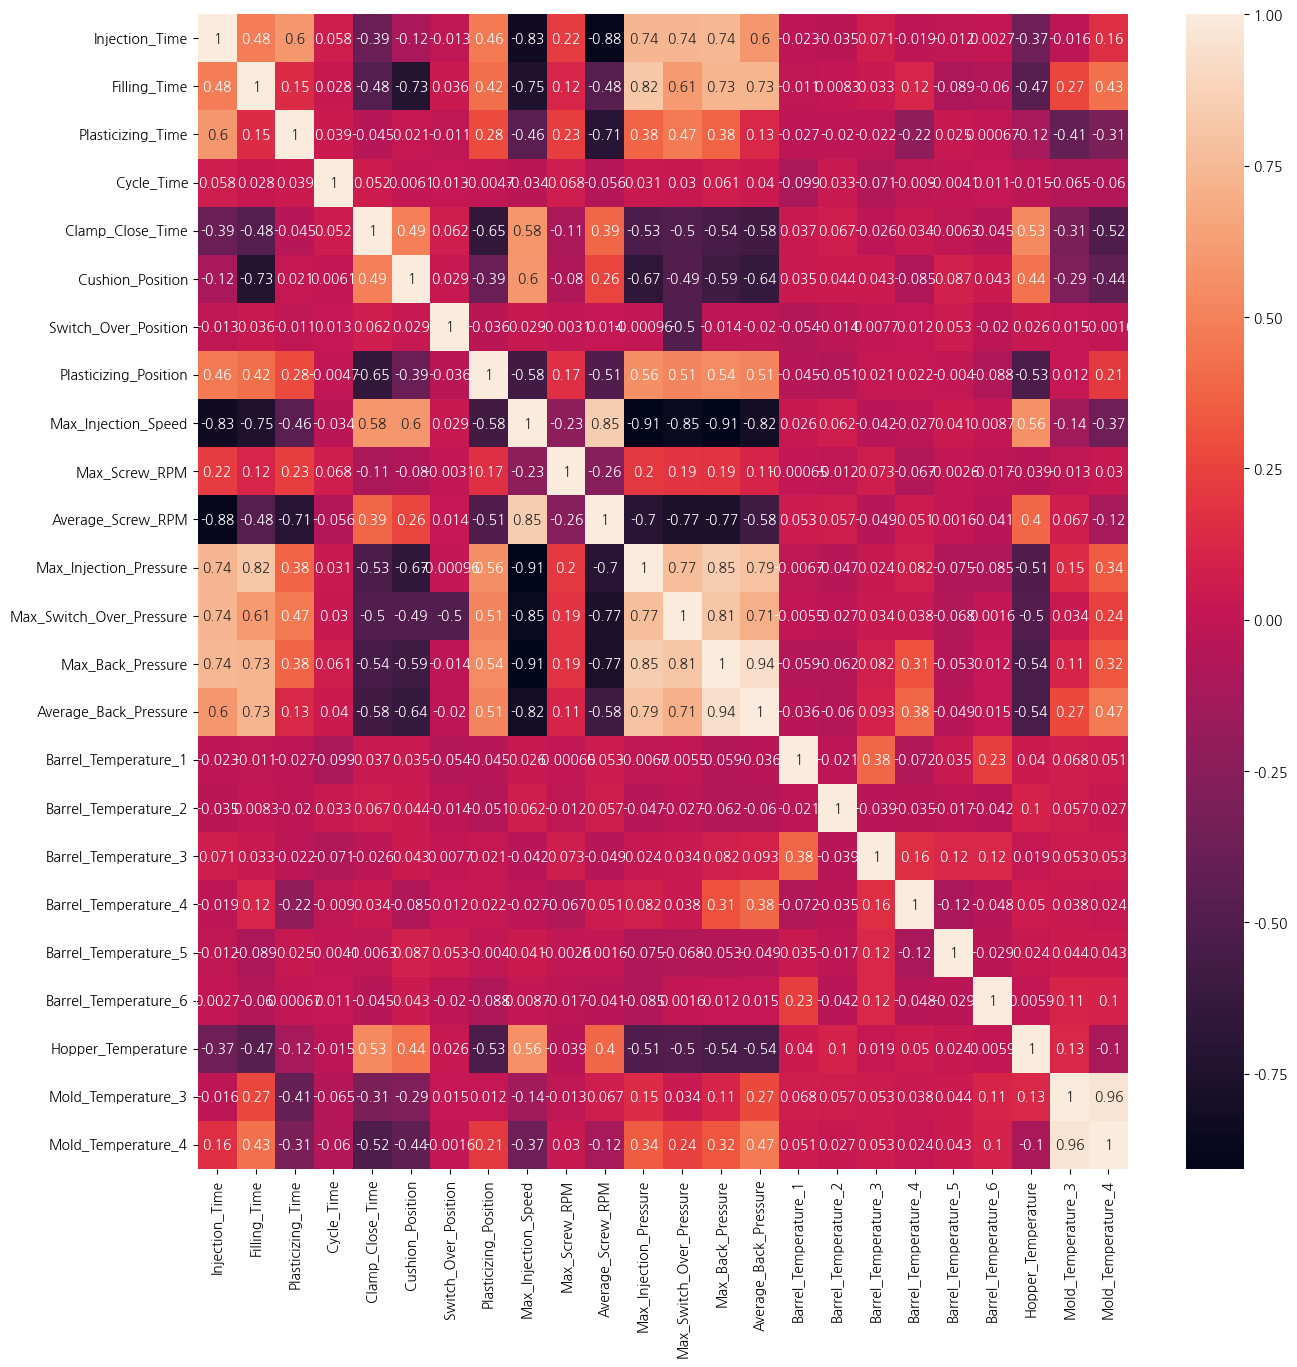

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_rg3_Y.corr(numeric_only=True), annot=True, ax=ax)
plt.show()

In [ ]:
lst = ["Clamp_Open_Position", "Barrel_Temperature_7", "Mold_Temperature_1", "Mold_Temperature_2",
       "Mold_Temperature_5", "Mold_Temperature_6", "Mold_Temperature_7", "Mold_Temperature_8",
       "Mold_Temperature_9", "Mold_Temperature_10", "Mold_Temperature_11", "Mold_Temperature_12",]

df_cn7 = df_cn7.drop(columns=lst)
df_rg3 = df_rg3.drop(columns=lst)

df_cn7.shape, df_rg3.shape

((3974, 33), (1256, 33))

In [ ]:
df_rg3_Y = df_rg3[df_rg3["PassOrFail"]=="Y"]
df_rg3_N = df_rg3[df_rg3["PassOrFail"]=="N"]

df_rg3_Y.shape, df_rg3_N.shape

((1224, 33), (32, 33))

In [ ]:
df_cn7_Y.columns

Index(['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_NAME', 'EQUIP_CD',
       'EQUIP_NAME', 'PassOrFail', 'Reason', 'Injection_Time', 'Filling_Time',
       'Plasticizing_Time', 'Cycle_Time', 'Clamp_Close_Time',
       'Cushion_Position', 'Plasticizing_Position', 'Clamp_Open_Position',
       'Max_Injection_Speed', 'Max_Screw_RPM', 'Average_Screw_RPM',
       'Max_Injection_Pressure', 'Max_Switch_Over_Pressure',
       'Max_Back_Pressure', 'Average_Back_Pressure', 'Barrel_Temperature_1',
       'Barrel_Temperature_2', 'Barrel_Temperature_3', 'Barrel_Temperature_4',
       'Barrel_Temperature_5', 'Barrel_Temperature_6', 'Hopper_Temperature',
       'Mold_Temperature_3', 'Mold_Temperature_4'],
      dtype='object')

In [ ]:
df_cn7_N.columns

Index(['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL',
       'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'PassOrFail', 'Reason',
       'Injection_Time', 'Filling_Time', 'Plasticizing_Time', 'Cycle_Time',
       'Clamp_Close_Time', 'Cushion_Position', 'Plasticizing_Position',
       'Clamp_Open_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'],
      dtype='object')

In [ ]:
# df_cn7_Y = df_cn7_Y.drop(columns=["PART_FACT_SERIAL"])
l = ["PART_FACT_SERIAL", "Clamp_Open_Position"]
df_cn7_N = df_cn7_N.drop(columns=l)

In [ ]:
df_cn7_N = df_cn7_N.drop(columns=l)

In [ ]:
df_cn7.drop(columns=["PART_FACT_SERIAL"], inplace=True)
df_rg3.drop(columns=["PART_FACT_SERIAL"], inplace=True)

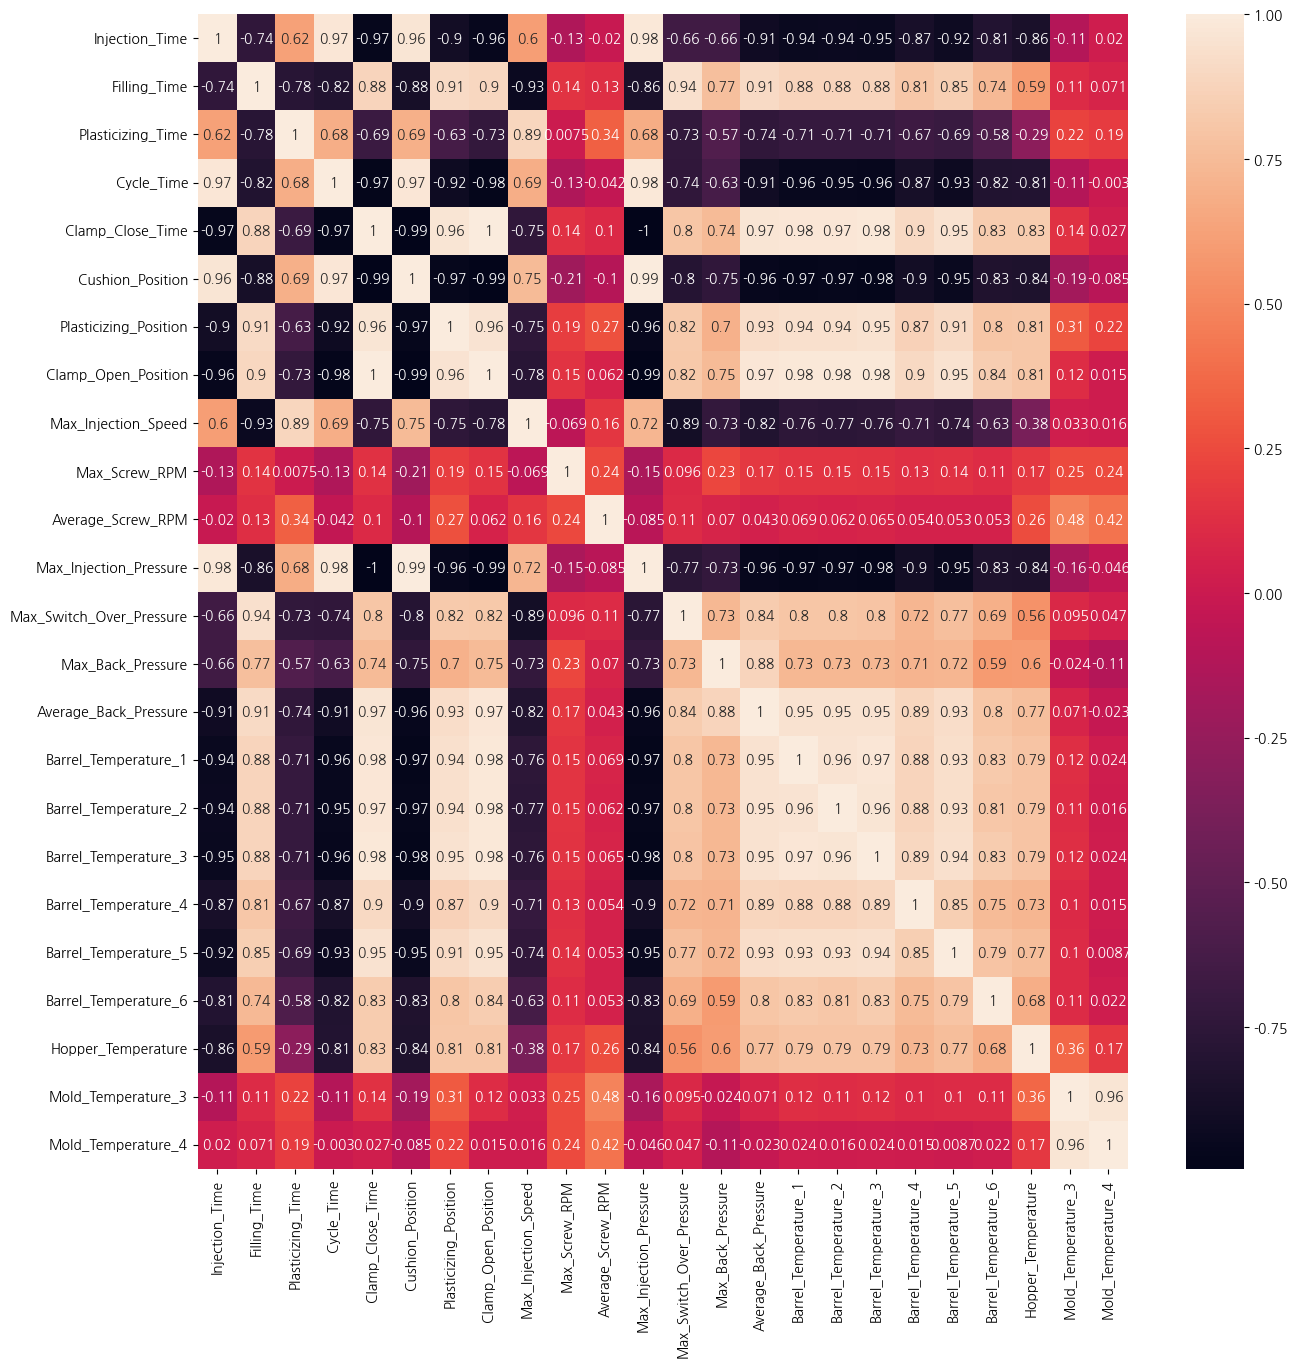

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_cn7_Y.corr(numeric_only=True), annot=True, ax=ax)
plt.show()

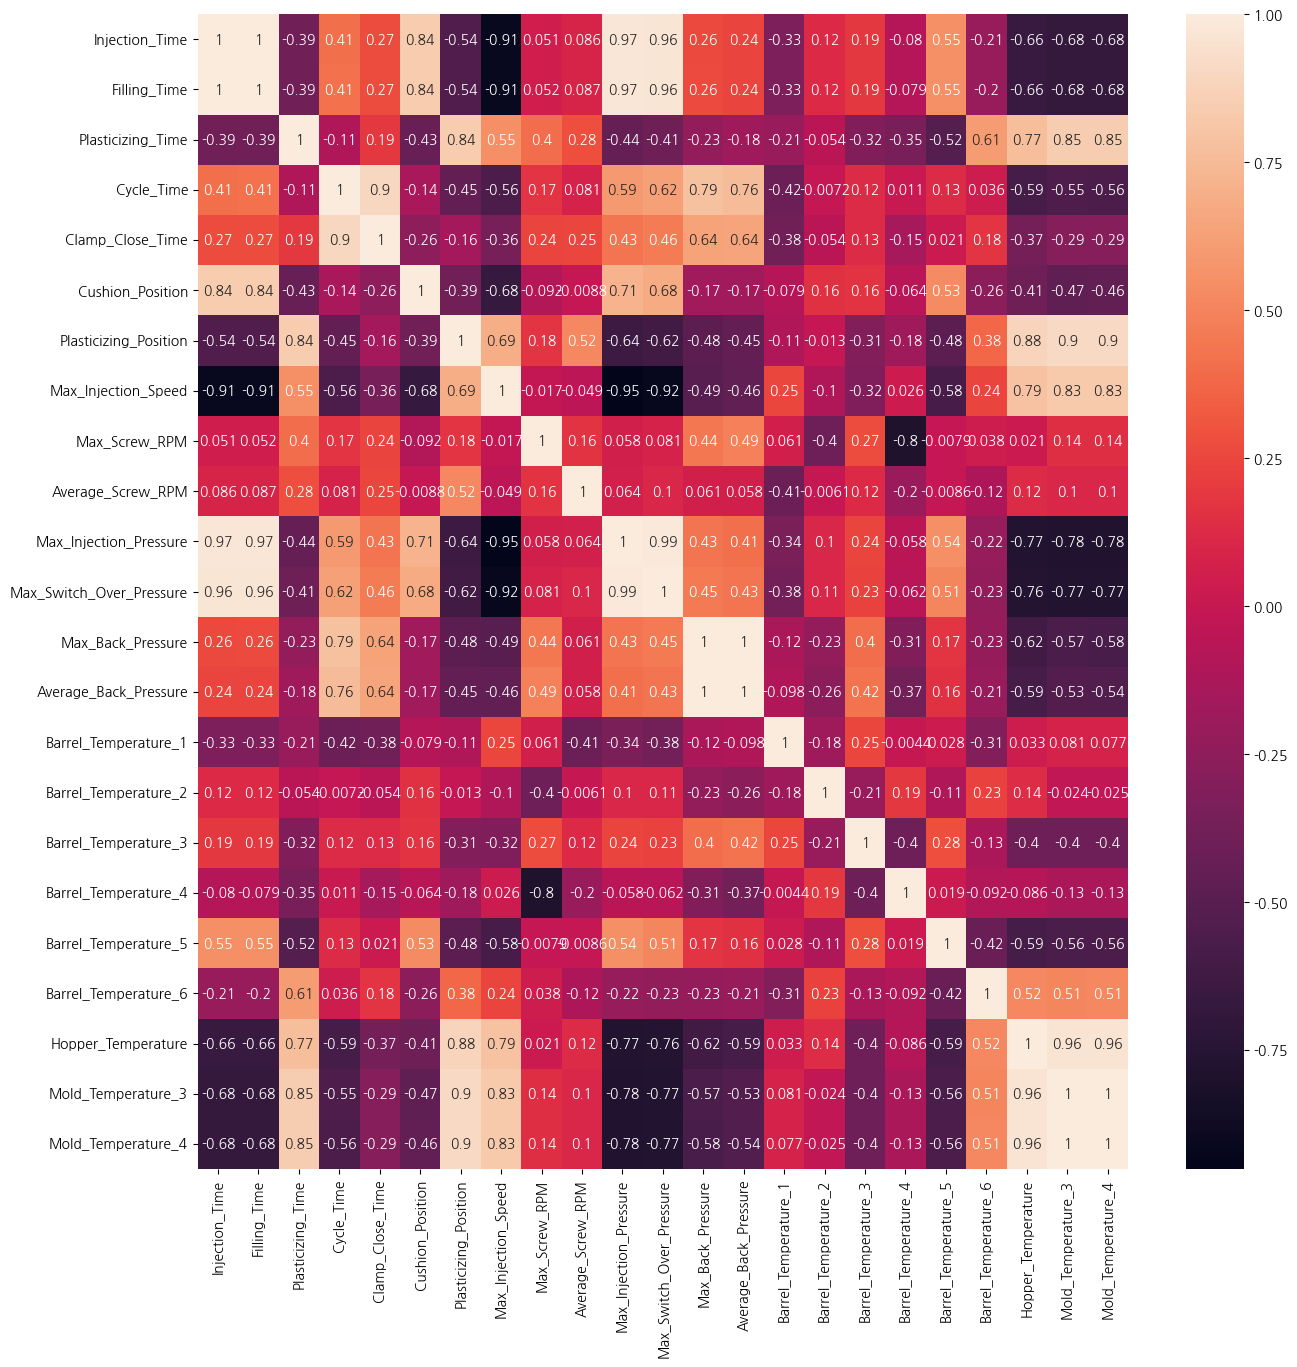

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_cn7_N.corr(numeric_only=True), annot=True, ax=ax)
plt.show()

##### 정상

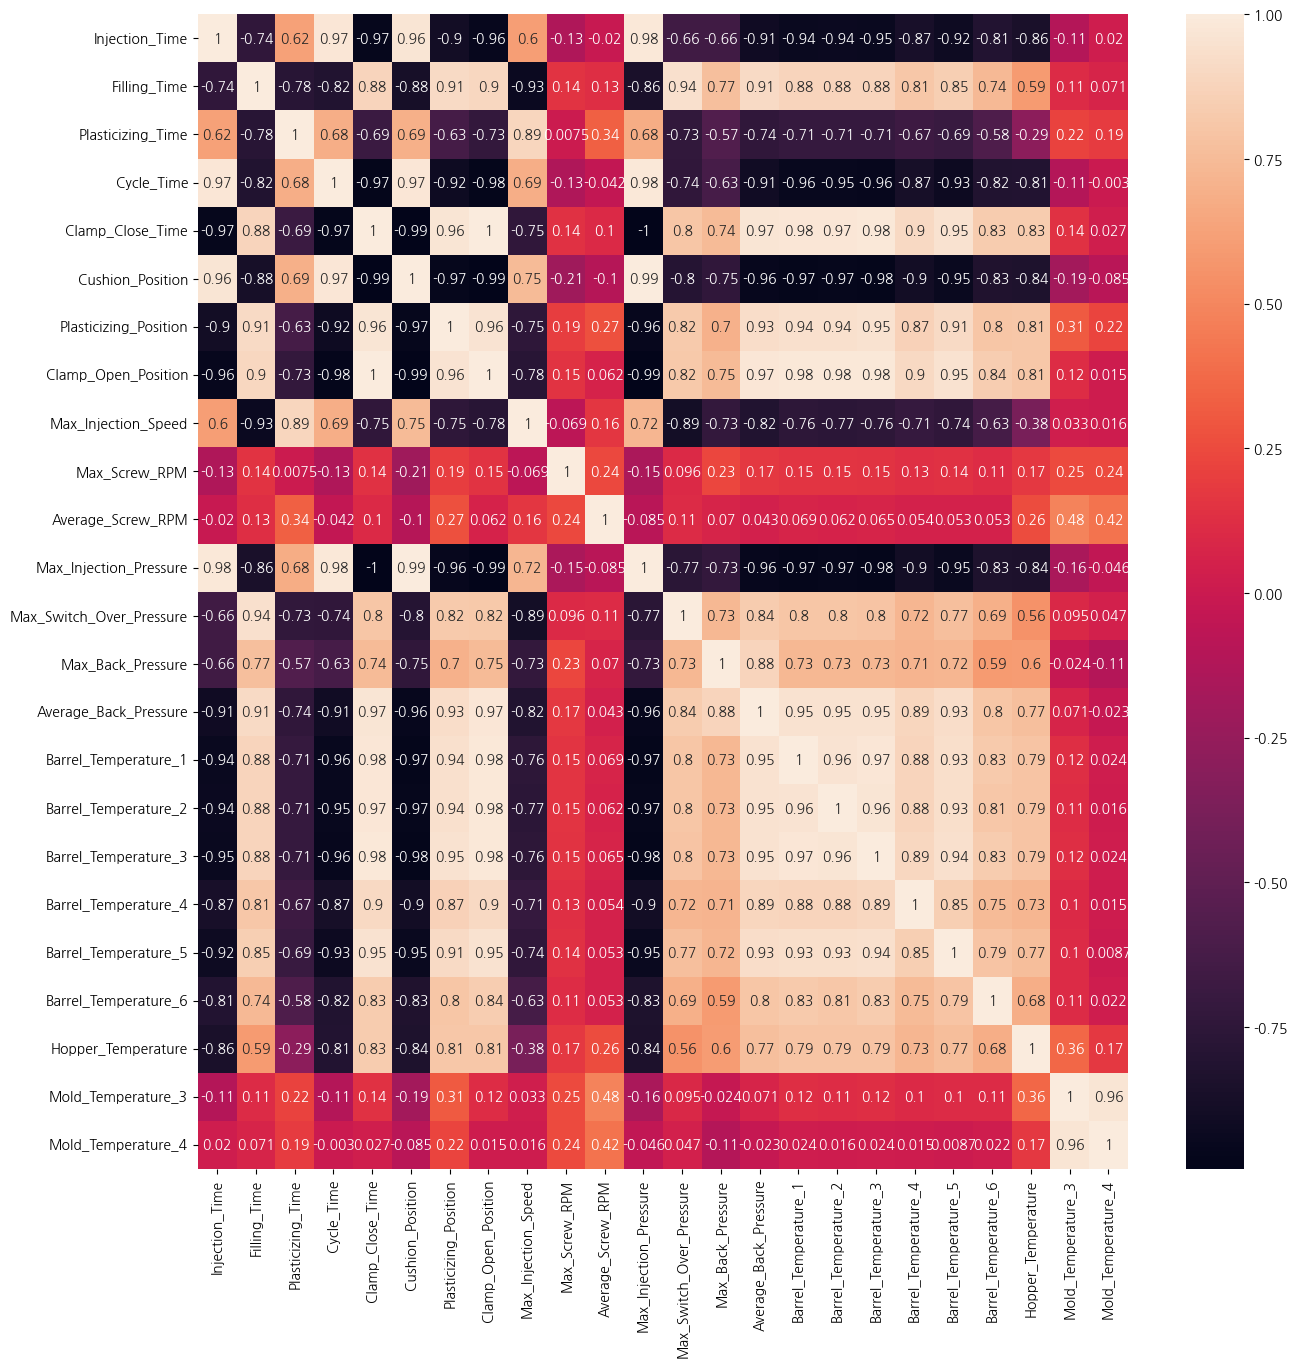

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_cn7_Y.corr(numeric_only=True), annot=True, ax=ax)
plt.show()

##### 불량

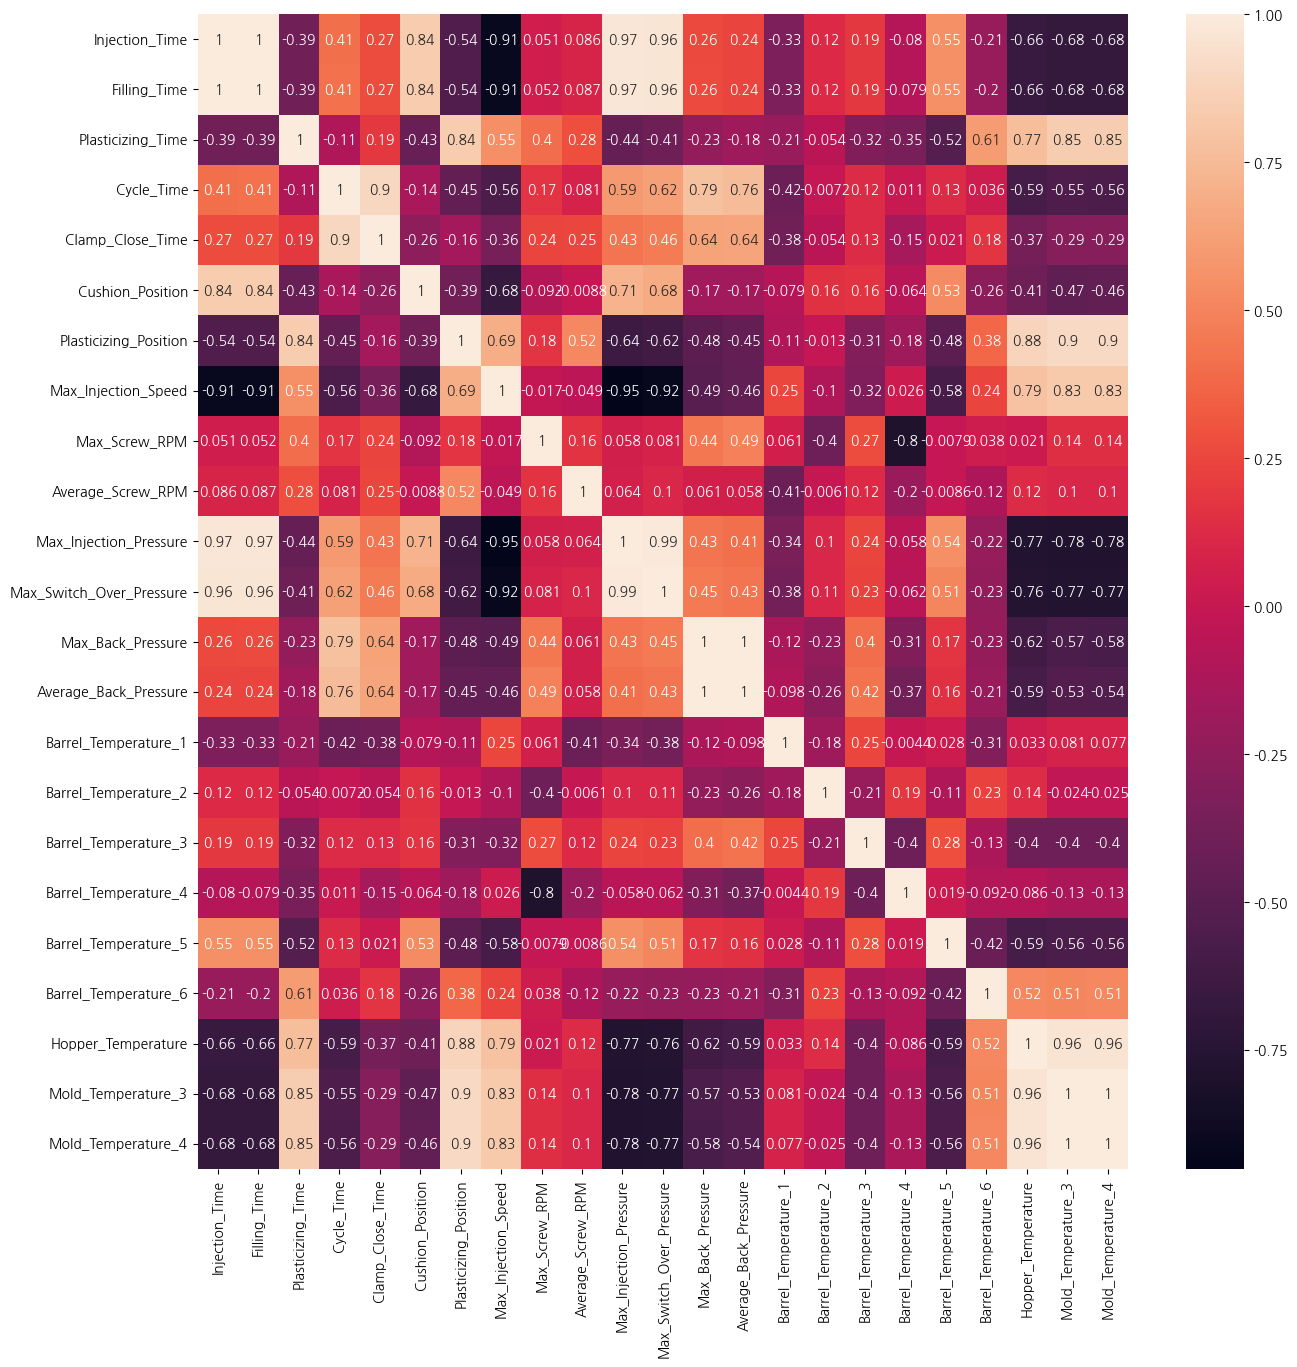

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_cn7_N.corr(numeric_only=True), annot=True, ax=ax)
plt.show()

#### Unlabeled

##### ERR Zero

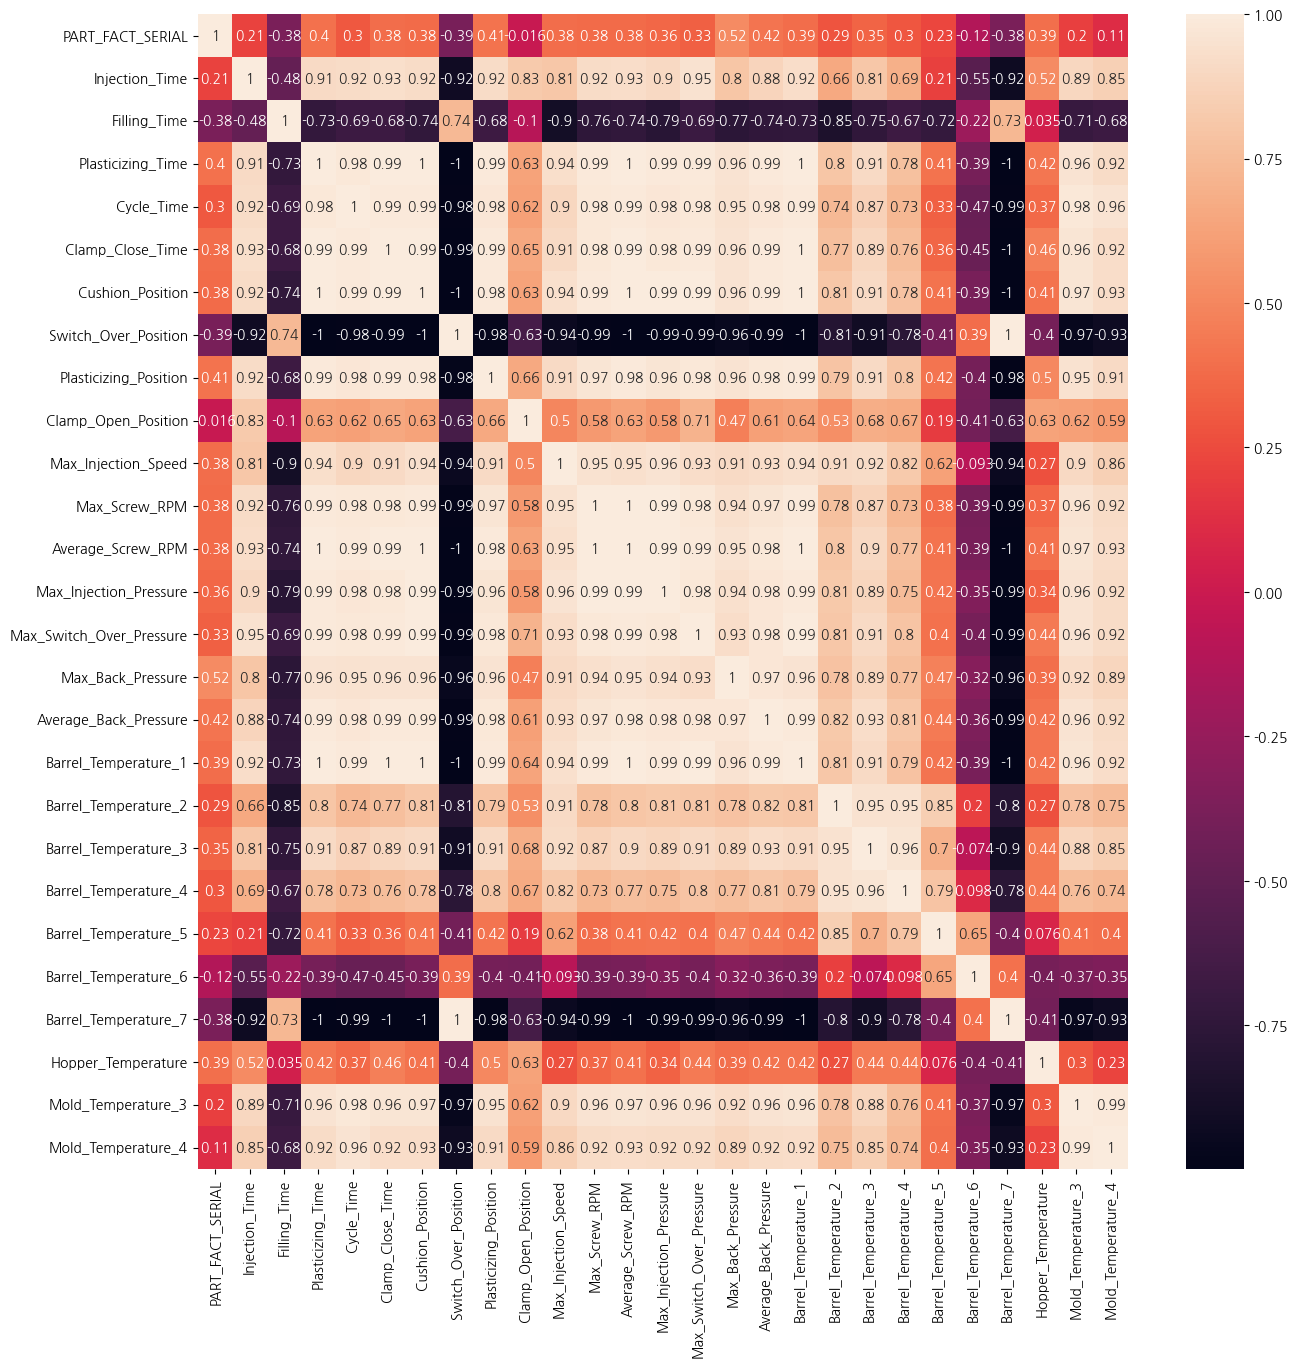

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(err_zero_cn7.corr(numeric_only=True), annot=True, ax=ax)
plt.show()

In [ ]:
err_zero_cn7["Plasticizing_Time"]

11764    17.96
11765    18.00
11766    17.96
11767    17.96
11768    17.94
         ...  
51703    16.97
51705    16.98
51707    16.97
51709    16.97
51711    16.96
Name: Plasticizing_Time, Length: 4774, dtype: float64

In [ ]:
err_zero_cn7["Barrel_Temperature_1"]

11764    270.9
11765    271.7
11766    270.9
11767    270.5
11768    271.5
         ...  
51703    275.5
51705    275.8
51707    276.7
51709    276.5
51711    275.9
Name: Barrel_Temperature_1, Length: 4774, dtype: float64

##### ERR None Zero

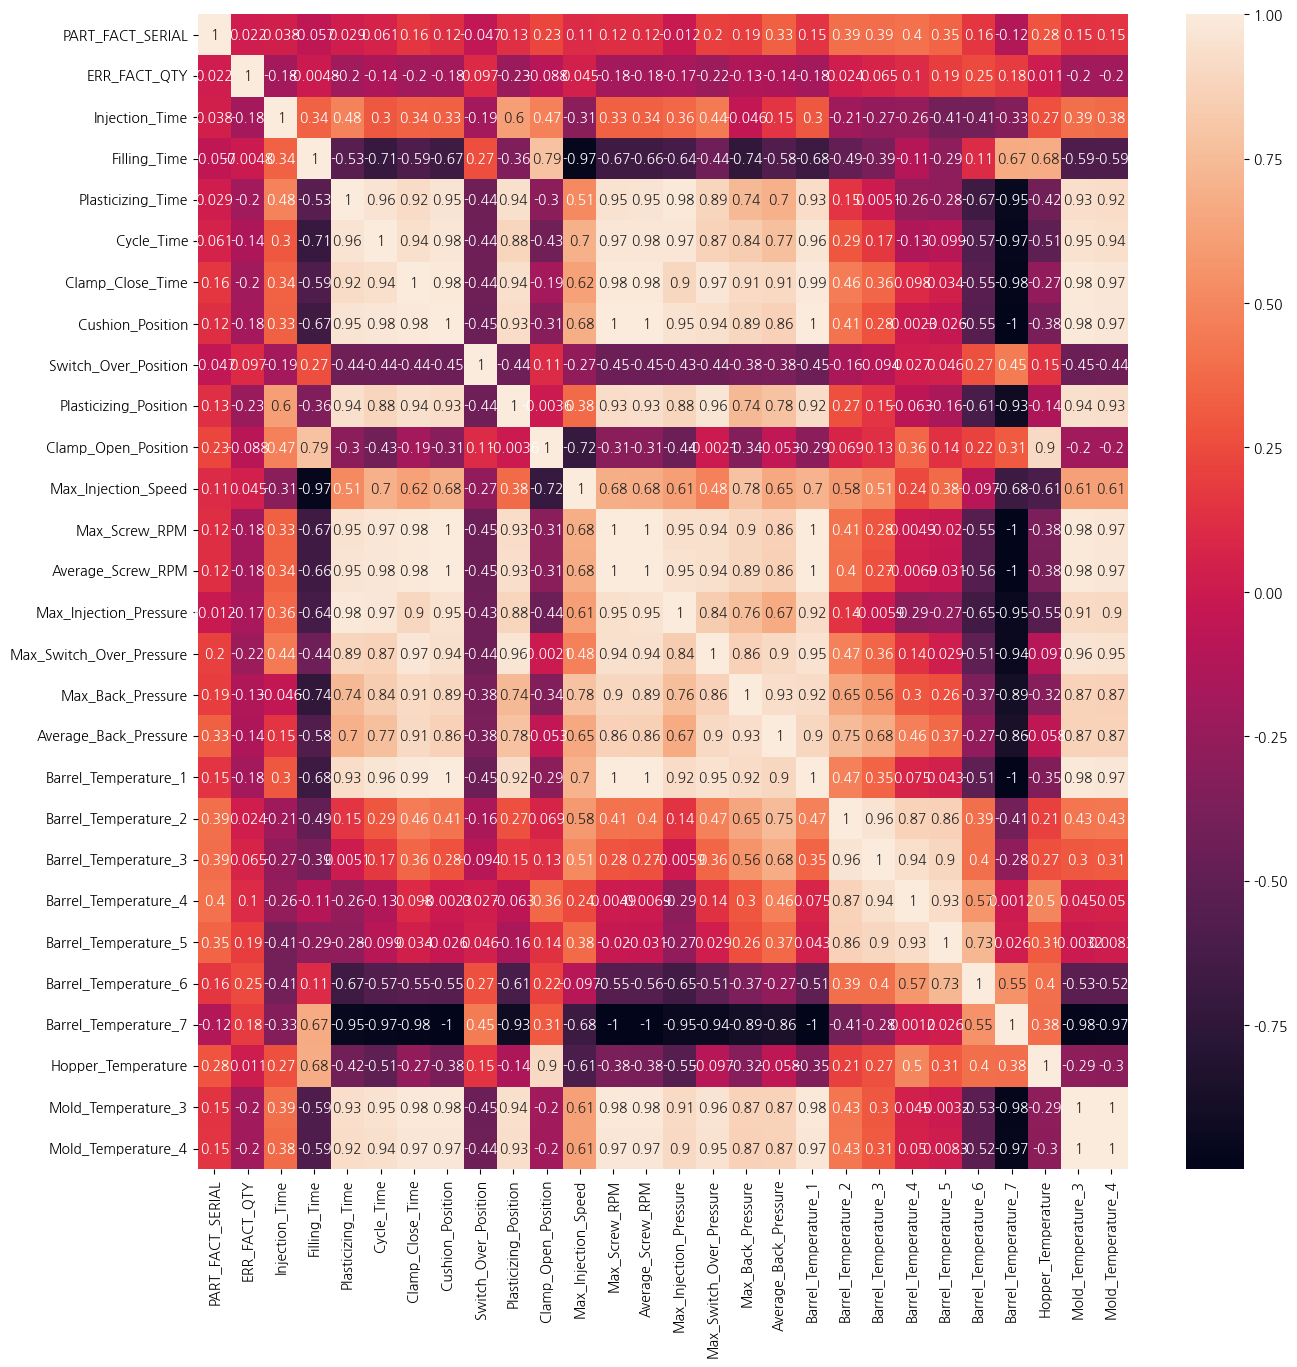

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(non_zero_cn7.corr(numeric_only=True), annot=True, ax=ax)
plt.show()

#### Histplot

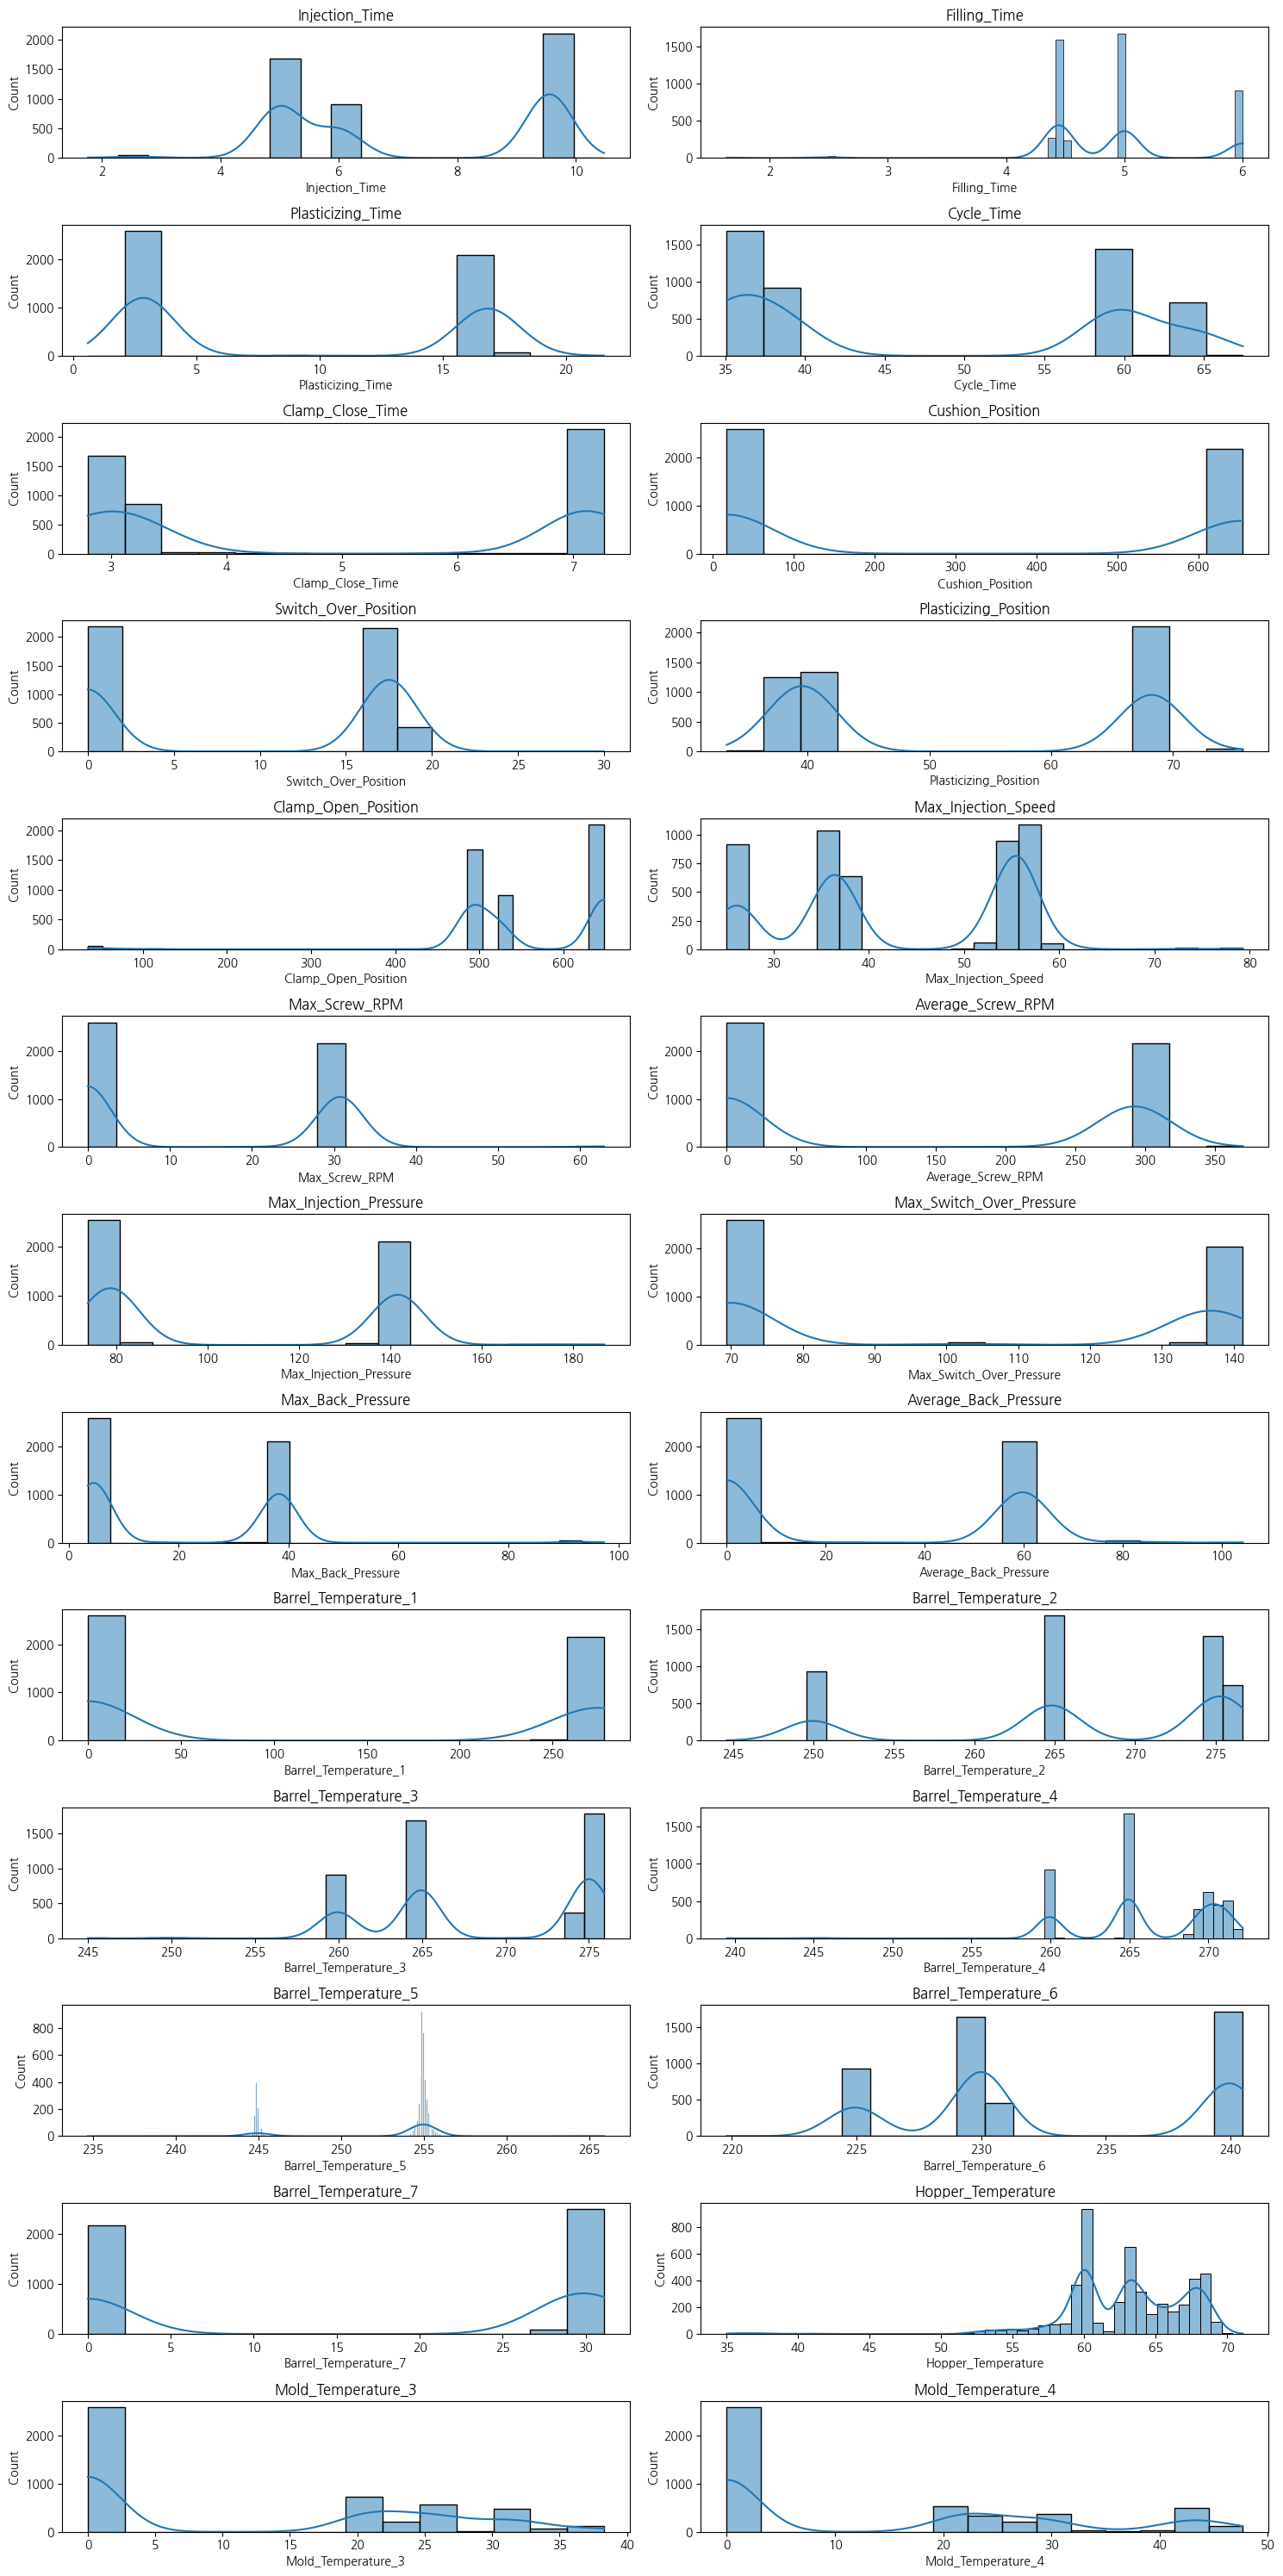

In [ ]:
plt.figure(figsize=(15, 30))

for i, column in enumerate(err_zero_cn7.select_dtypes(include="float"), 1):
    plt.subplot(13, 2, i)
    sns.histplot(err_zero_cn7[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

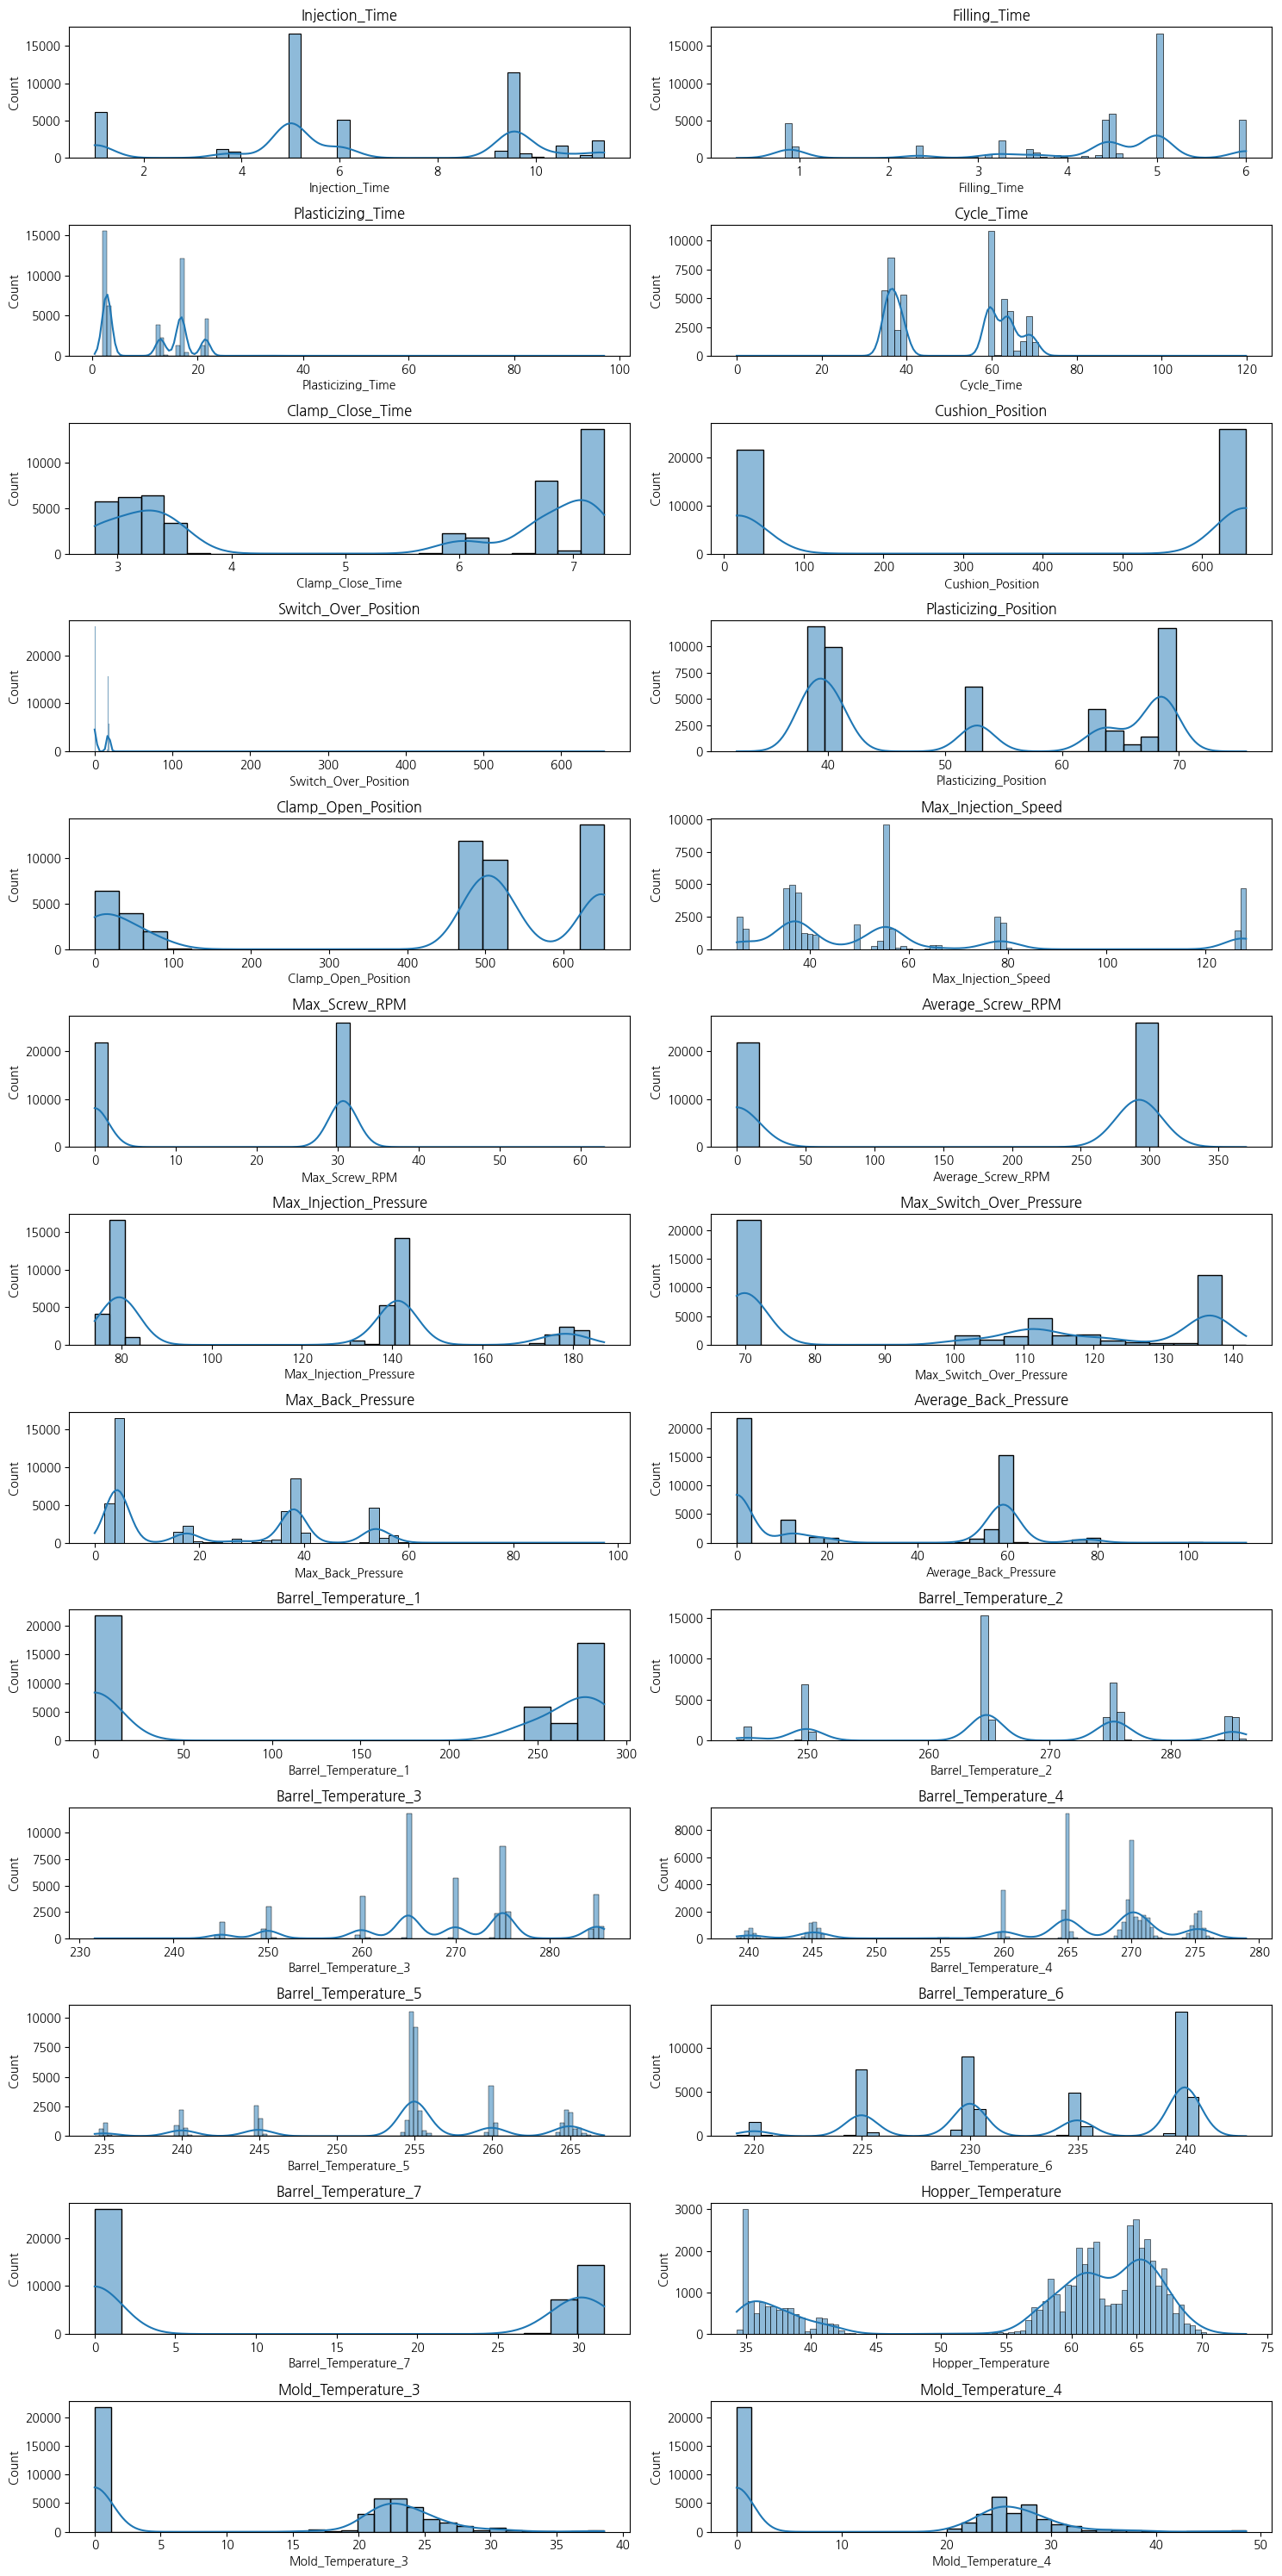

In [ ]:
plt.figure(figsize=(15, 30))

for i, column in enumerate(err_zero_cn7.select_dtypes(include="float"), 1):
    plt.subplot(13, 2, i)
    sns.histplot(non_zero_cn7[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

In [ ]:
cols = ['Injection_Time', 'Filling_Time', 'Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Switch_Over_Position', 'Plasticizing_Position', 'Clamp_Open_Position',
       'Max_Injection_Speed', 'Max_Screw_RPM', 'Average_Screw_RPM',
       'Max_Injection_Pressure', 'Max_Switch_Over_Pressure',
       'Max_Back_Pressure', 'Average_Back_Pressure', 'Barrel_Temperature_1',
       'Barrel_Temperature_2', 'Barrel_Temperature_3', 'Barrel_Temperature_4',
       'Barrel_Temperature_5', 'Barrel_Temperature_6', 'Barrel_Temperature_7',
       'Hopper_Temperature','Mold_Temperature_3', 'Mold_Temperature_4']

In [ ]:
for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(13, 6))

    sns.histplot(data=err_zero_cn7, x=col, hue="PART_NAME", kde=True, multiple="stack", ax=axes[0])
    axes[0].set_title(f"{col} (ERR_FACT_QTY = 0)", fontsize=12)

    sns.histplot(data=non_zero_cn7, x=col, hue="PART_NAME", kde=True, multiple="stack", ax=axes[1])
    axes[1].set_title(f"{col} (ERR_FACT_QTY > 0)", fontsize=12)

    file_name = os.path.join(DATA_PATH, f"{col}_analysis.png")
    plt.savefig(file_name, dpi=300, bbox_inches='tight')  # 저장

    plt.suptitle(f"Analysis for {col}", fontsize=16)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
unlab_cn7.columns

Index(['Unnamed: 0', '_id', 'TimeStamp', 'PART_FACT_PLAN_DATE',
       'PART_FACT_SERIAL', 'PART_NO', 'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME',
       'ERR_FACT_QTY', 'Injection_Time', 'Filling_Time', 'Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Switch_Over_Position', 'Plasticizing_Position', 'Clamp_Open_Position',
       'Max_Injection_Speed', 'Max_Screw_RPM', 'Average_Screw_RPM',
       'Max_Injection_Pressure', 'Max_Switch_Over_Pressure',
       'Max_Back_Pressure', 'Average_Back_Pressure', 'Barrel_Temperature_1',
       'Barrel_Temperature_2', 'Barrel_Temperature_3', 'Barrel_Temperature_4',
       'Barrel_Temperature_5', 'Barrel_Temperature_6', 'Barrel_Temperature_7',
       'Hopper_Temperature', 'Mold_Temperature_1', 'Mold_Temperature_2',
       'Mold_Temperature_3', 'Mold_Temperature_4', 'Mold_Temperature_5',
       'Mold_Temperature_6', 'Mold_Temperature_7', 'Mold_Temperature_8',
       'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_

In [ ]:
cols = ["Unnamed: 0", 'Mold_Temperature_1', 'Mold_Temperature_2',
       'Mold_Temperature_5', 'Mold_Temperature_6', 'Mold_Temperature_7',
        'Mold_Temperature_8','Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temperature_11',
       'Mold_Temperature_12']

unlab_cn7 = unlab_cn7.drop(columns=cols)
unlab_rg3 = unlab_rg3.drop(columns=cols)

unlab_cn7.shape, unlab_rg3.shape

((52547, 35), (37477, 35))

In [ ]:
unlab_cn7 = unlab_cn7.drop(columns=["PART_FACT_SERIAL"])
unlab_rg3 = unlab_rg3.drop(columns=["PART_FACT_SERIAL"])

unlab_cn7.shape, unlab_rg3.shape

((52547, 34), (37477, 34))

In [ ]:
unlab_cn7 = unlab_cn7.drop(columns=["ERR_FACT_QTY"])
unlab_rg3 = unlab_rg3.drop(columns=["ERR_FACT_QTY"])

unlab_cn7.shape, unlab_rg3.shape

((52547, 33), (37477, 33))

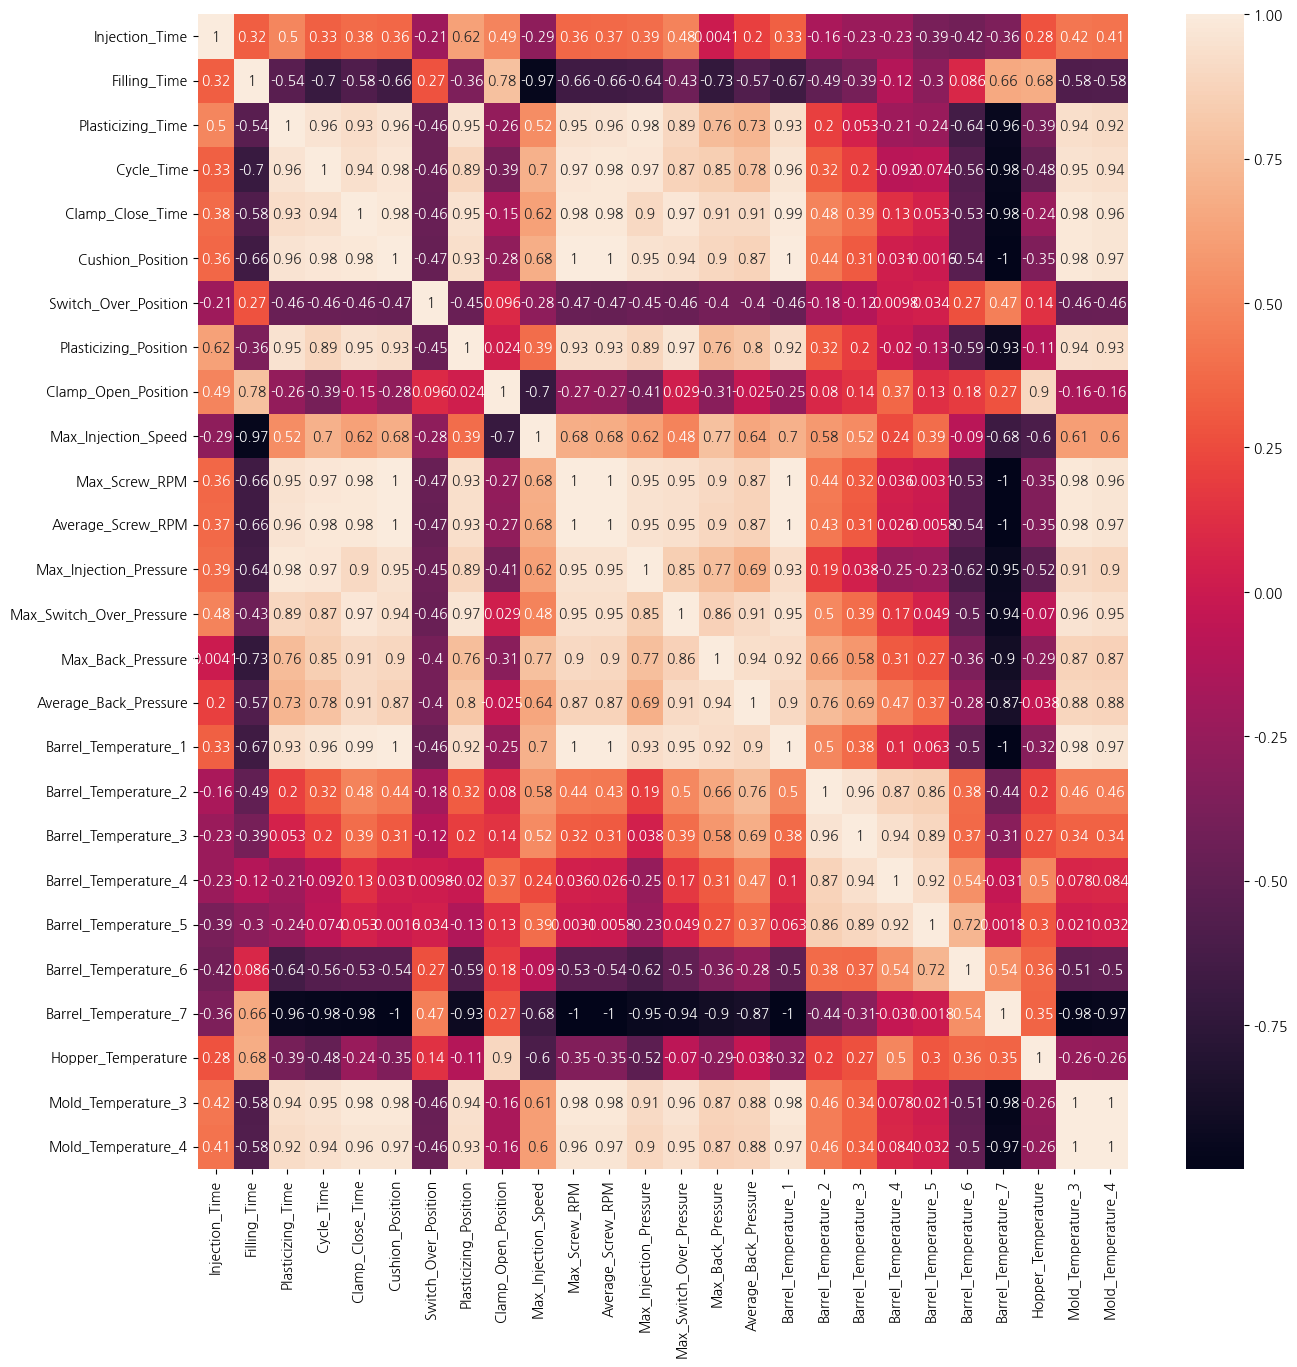

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(unlab_cn7.corr(numeric_only=True), annot=True, ax=ax)
plt.show()

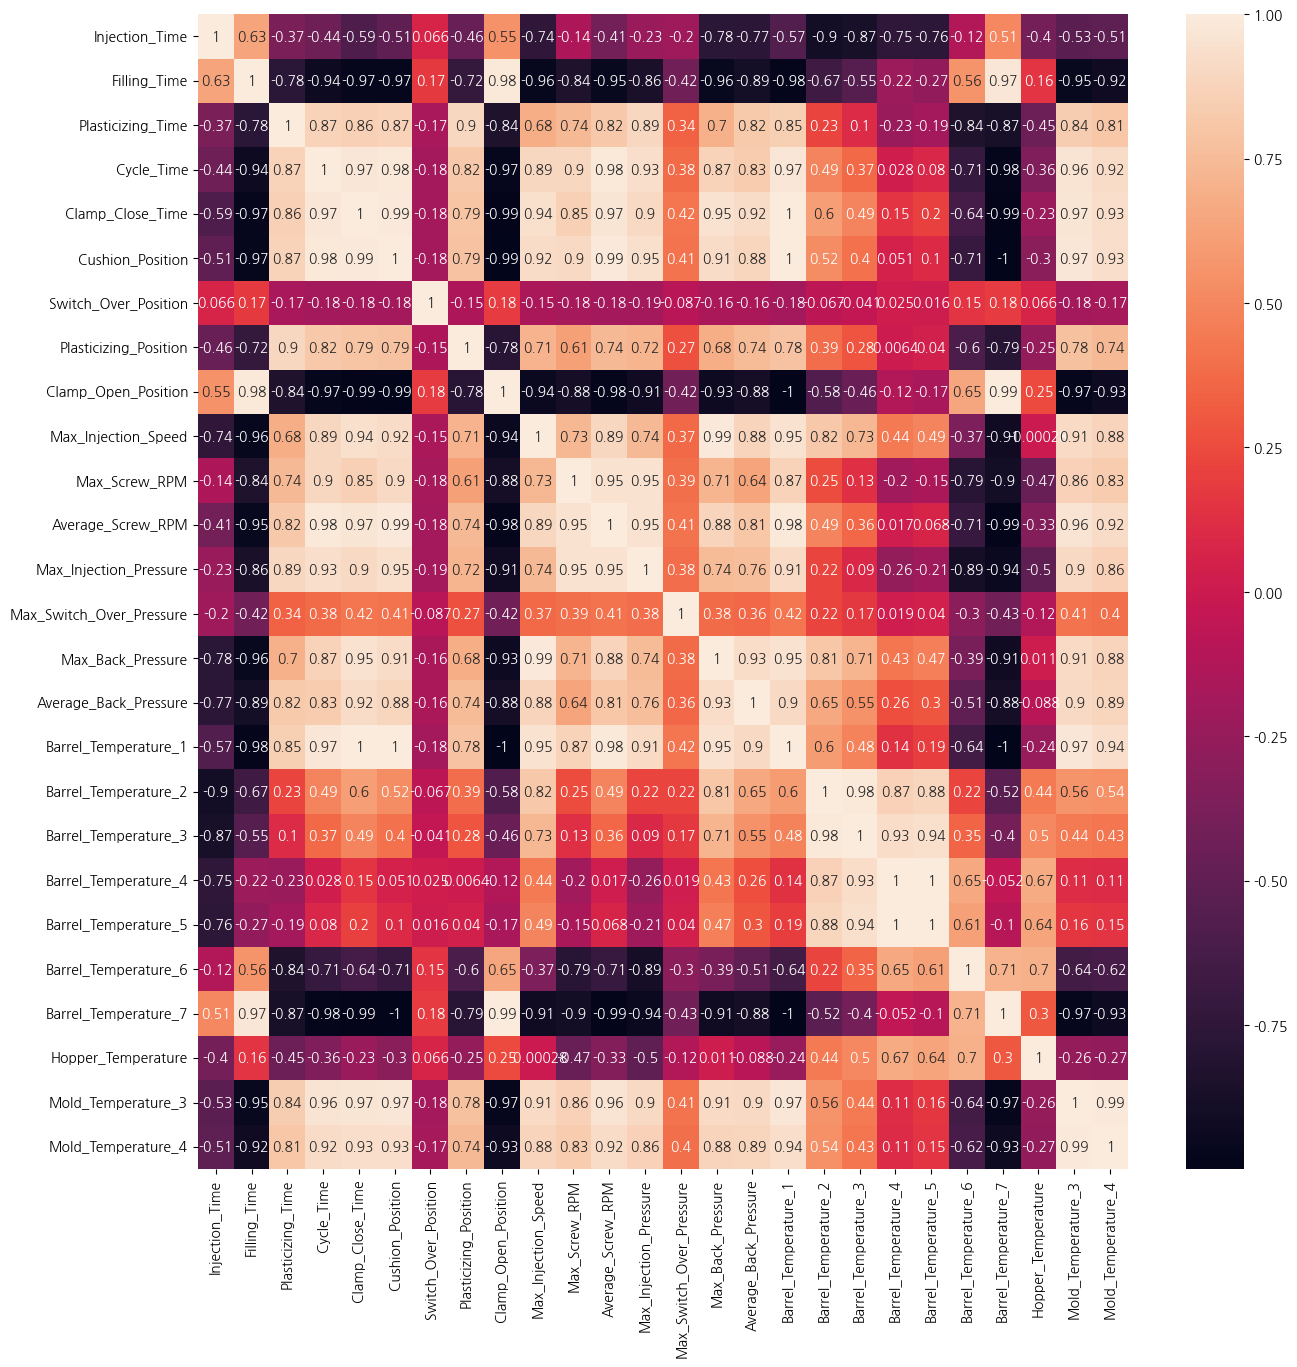

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(unlab_rg3.corr(numeric_only=True), annot=True, ax=ax)
plt.show()

In [ ]:
cols = ['Injection_Time', 'Filling_Time',
       'Plasticizing_Time', 'Cycle_Time', 'Clamp_Close_Time',
       'Cushion_Position', 'Switch_Over_Position', 'Plasticizing_Position',
       'Clamp_Open_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Barrel_Temperature_7', 'Hopper_Temperature',
       'Mold_Temperature_3', 'Mold_Temperature_4']

In [ ]:
for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(13, 6))

    sns.histplot(data=unlab_cn7, x=col, hue="PART_NAME", kde=True, multiple="stack", ax=axes[0])
    axes[0].set_title(f"{col} in unlab_cn7", fontsize=12)

    sns.histplot(data=unlab_rg3, x=col, hue="PART_NAME", kde=True, multiple="stack", ax=axes[1])
    axes[1].set_title(f"{col} in unlab_rg3", fontsize=12)

    # file_name = os.path.join(DATA_PATH, f"{col}_analysis.png")
    # plt.savefig(file_name, dpi=300, bbox_inches='tight')  # 저장

    plt.suptitle(f"Analysis for {col}", fontsize=16)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
unlab_cn7.columns

Index(['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_NO', 'PART_NAME',
       'EQUIP_CD', 'EQUIP_NAME', 'Injection_Time', 'Filling_Time',
       'Plasticizing_Time', 'Cycle_Time', 'Clamp_Close_Time',
       'Cushion_Position', 'Switch_Over_Position', 'Plasticizing_Position',
       'Clamp_Open_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Barrel_Temperature_7', 'Hopper_Temperature',
       'Mold_Temperature_3', 'Mold_Temperature_4'],
      dtype='object')